In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import numpy as np 
from numpy import abs as Abs
from numpy import sign as sign

from control.matlab import *  # MATLAB-like functions
import control as ct
from scipy import signal
from scipy.signal import butter, filtfilt
 
 
import matplotlib
import matplotlib.pyplot as plt
 
import tensorflow as tf
from gym import Env
from gym.spaces import Discrete, Box
 
import random
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [3]:
# Quarter car model
M = 600  # Body mass (in Kg)
m = 75  # Mass of tyre (in Kg)
Ks = 30  # Spring constant
Kt = 300  # Spring constant of wheel
Cs = 400  # Damping coefficient
n = 2  # DOF
r = 1  # No of Actuator

# MR Damper
V = 20
K1 = 542.18
K2 = 550.16
C1 = 999.4
C2 = 3387.5
alpha  = 3846.2 
beta = 126.84
gamma = 303.83 
A1 = 96.067
N = 3

# State space representation (states - y1, y2, dot(y1), dot(y2)) 
# Continous time
A =np.array([[0 ,0 ,1 ,0 ],
              [0 ,0 ,0 ,1 ],
              [-Ks/M, Ks/M, 0, 0],
              [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
# Input matrix (Control force and Earthquake input)
B  = np.array([[0,0,1/M,-1/m]]).T
# Influence vector (Earthquake input)
E = np.array([[0,0,0,Kt/m]]).T 
# Output matrix (Disp + Accel)
Cd = np.array([[1, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
Dd = np.array([[0, 1/M, -1/m]]).T
Ed = np.array([[0, 0, 0]]).T

[[  1932.66537349]
 [  2741.09860147]
 [  3660.46019273]
 [355278.00285061]
 [357850.42669676]
 [359866.7862777 ]] [[ 1482.24797511]
 [ 2183.49055944]
 [ 2765.3578496 ]
 [81167.19340063]
 [81887.51209244]
 [82831.08107074]]


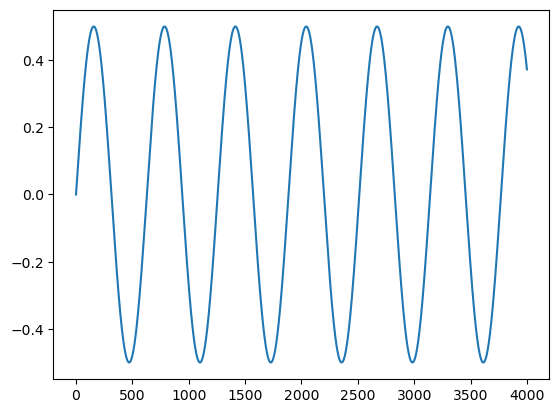

In [4]:
# Input Sinusoid
T = 40
dt = 0.01
t = np.arange(0, T+dt, dt)
omega1 = 1
omega2 = 0
amplitude   = 0.5*(np.sin(omega1*t) + np.sin(omega2*t))
plt.plot(amplitude)

Qp = np.array([[Ks, -Ks, 0, 0],
               [-Ks, Ks+Kt, 0, 0],
               [0, 0, M, 0],
               [0, 0, 0, m]])
# print(Qp)
(i,j)=B.shape
Rp =  (10**(0))*np.identity(j)
Kp1, Sp1, ep1 = ct.lqr(A, B, Qp, Rp)
del i, j

T = 40
dt = 0.01
t = np.arange(0, T+dt, dt)
nt = len(t)
x_uc = np.zeros([nt, 2*n, 6])
y_uc = np.zeros([nt, n, 6])
x_c = np.zeros([nt, 2*n, 6])
y_c = np.zeros([nt, n, 6])
J1_val = np.zeros([6, 1])
J2_val = np.zeros([6, 1])
U = np.zeros([nt, 6])


# Input Sinusoid (Resonant Frequencies)
k = 0
for i in range(1, 3):
    for j in range(0, 3):
        omega1 = i
        omega2 = j/10
        amplitude = 0.5*(np.sin(omega1*t) + np.sin(omega2*t))
        
        # Openloop
        sys_uc = signal.StateSpace(A, E, Cd, np.array([[0, 0, 0]]).T)
        t1,y1,x1 = signal.lsim(sys_uc,amplitude,t)
        x_uc[:, :, k] = x1
        y_uc[:, :, k] = y1[:, 1:3]
        del t1, y1, x1

        sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
        t2,y2,x2 = signal.lsim(sys_c,amplitude,t)
        x_c[:, :, k] = x2
        y_c[:, :, k] = y2[:, 1:3]
        del t2, y2, x2
        k = k+1
del i, j, k
for k in range(0, 6):
    for tkk in range(0,len(t)):
        U[tkk, k] = Kp1@x_uc[tkk,:,k].T
        En1 = 0.5*((x_uc[tkk,:,k]@Qp)@x_uc[tkk,:,k].T)
        En2 = 0.5*((x_c[tkk,:,k]@Qp)@x_c[tkk,:,k].T)
        J1 = dt*En1
        J2 = dt*En2
        J1_val[k] += J1 
        J2_val[k] += J2
print(J1_val, J2_val)

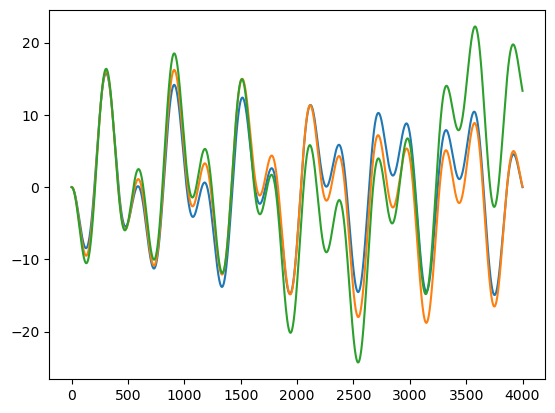

In [5]:
plt.plot(U[:, 0:3])

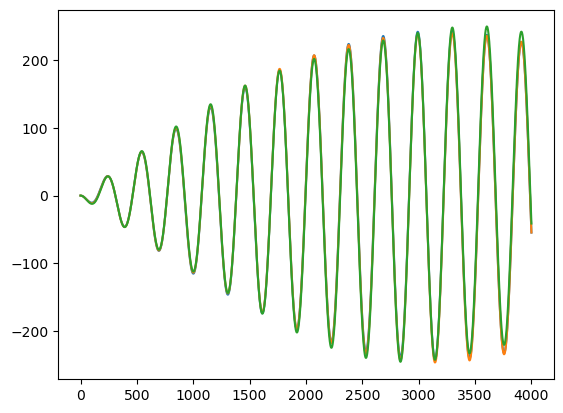

In [6]:
 plt.plot(U[:, 3:6])

In [7]:
class MrDamperEnv(Env):

    def __init__(self):
      # System parameters         
      self.Ad = 0.45 
      self.V = 20
      self.M = 600
      self.m = 75
      self.Ks = 30
      self.Cs = 400
      self.Kt = 300
      self.K1 = 542.18
      self.K2 = 550.16
      self.C1  =999.4 
      self.C2  = 3387.5 
      self.A1 = 96.067
      self.n = 2
      self.r = 1
      self.umin = 0.02  
      self.umax = 1 
    
      # Plant matrix         
      self.A =np.array([[0, 0, 1, 0],
                        [0, 0, 0, 1],
                        [-self.Ks/self.M, self.Ks/self.M, 0, 0],
                        [self.Ks/self.m, -1*(self.Ks+self.Kt)/self.m, 0, 0]])
      # Input matrix (Control force)
      self.B  = np.array([[0, 0, 1/self.M, -1/self.m]]).T
      # Influence vector (Earthquake input)
      self.E = np.array([[0, 0, 0, self.Kt/self.m]]).T 
      # Output matrix (Disp + Accel)
      self.Cd = np.array([[1, 1, 0, 0], [-self.Ks/self.M, self.Ks/self.M, 0, 0], [self.Ks/self.m, -1*(self.Ks+self.Kt)/self.m, 0, 0]])
      self.Dd = np.array([[0, 1/self.M, -1/self.m]]).T
      self.Ed = np.array([[0, 0, 0]]).T
      # Weighting matrices     
      self.Q = np.array([[self.Ks, -self.Ks, 0, 0],
                         [-self.Ks, self.Ks+self.Kt, 0, 0],
                         [0, 0, self.M, 0],
                         [0, 0, 0, self.m]])
      (i,j) = self.B.shape 
      self.R = np.identity(j)
      Kp1, Sp1, ep1 = ct.lqr(self.A, self.B, self.Q, self.R)
      del i,j, Sp1, ep1
      
        
      # Input per episode       
      self.T = 40
      self.dt = 0.01
      self.t = np.arange(0, self.T+self.dt, self.dt)
      #self.omega1 = np.random.randint(low=1,high=3)
      #self.omega2 = np.random.randint(low=0,high=3)
      self.x_uf = np.random.normal(0, 1, size=len(self.t))
      self.fc = 3       # Cutoff frequency (Hz)
      self.order = 4    # Filter order

      # Design the Butterworth filter
      self.nyquist_rate = 0.5 * 1/self.dt
      self.cutoff_freq = self.fc / self.nyquist_rate
      self.b, self.a = butter(self.order, self.cutoff_freq, 'low')
      self.amplitude = filtfilt(self.b, self.a, self.x_uf)
      nt = self.t.size
      # System Dynamics
          
      # Initialize variables
      self.time_current = 0
      self.state = np.zeros([nt, 2*self.n]) # states (ys,ysdot,yt,ytdot)
      self.U = np.zeros([nt, 1]) # Control force (action)
      self.Re = np.zeros([nt, 1]) # Reward
      self.J_val = 0
      self.action_space = Box(low=-100, high=100,shape=(1,)) 
      self.observation_space = Box(low=np.array([-100000, -100000, -100000, -100000]), high=np.array([100000, 100000, 100000, 100000]) )
      self.statem = np.zeros([1, 2*self.n])
      self.Volt = np.zeros([nt, 1])
      self.K = np.zeros([2*self.n, 2*self.n])
      self.hr = []
      self.en = []
      self.values =  [[],[],[],[]] 

    def step(self, action):
           
          tim = self.time_current  # current time (size 1)
          self.en.append(action)         
          A = self.A 
          B = self.B
          E = self.E
          Cd = self.Cd
          Dd = self.Dd
          Ed = self.Ed
          Q = self.Q
          R = self.R  
          n = self.n
          r = self.r
          dt = self.dt
          umin = self.umin  
          umax = self.umax
          Kp, Sp, ep = ct.lqr(A, B, Q, R)
            
          # Control action
          K = self.K
          #print(K)
          state = np.array([self.state[tim, :]]).T
          val = ((state.T)@K)@(state)
          if(val[0] >= 0):
                self.U[tim, :] = (-umin*(Kp@state)) + action
                self.Volt[tim, :] = umin
          else:
                self.U[tim, :] = (-umax*(Kp@state)) + action
                self.Volt[tim, :] = umax
          #print(tim, self.U[tim, :], self.state[tim, :], self.Re[tim, :])
          action = np.array([self.U[tim, :]]).T
        
          self.J = 0
          z = 20 + tim
          i = 0
          for tkk in range(tim, z):
            h = self.amplitude[tkk] 
            self.hr.append(h)
            xn = state
            # print(self.U[tim, :])
            Bu = action*B
            f = h*E 
            D = f + Bu
            k1 = dt*((A@xn) + D)
            k2 = dt*(A@(xn + 0.5*k1)+ D)
            k3 = dt*(A@(xn + 0.5*k2)+ D)
            k4 = dt*(A@(xn + k3)+ D)
            xn1 = xn + (k1 + 2*k2 + 2*k3 + k4)/6
            #f1.append(xn1[0][0])
            # print(xn1)
            state = xn1
            
            self.En = 0.5*((state.T@Q)@state)
            #print(self.E)
            self.J = self.J + dt*(0.9**i)*(self.En)
            
            if(i==0):
              self.statem = state.T
              self.J_val += self.J 
            i = i+1
          #print("kkk ",self.J_val)
          #print(self.J) 
          done = False
          #print(f1)
          info = {}   
          reward = -1*self.J
          self.Re[tim+1, :] = reward
          self.state[tim+1, :] = self.statem
          self.values[0].append(self.statem[0][0])  
          self.values[1].append(self.statem[0][1])
          self.values[2].append(self.statem[0][2])
          self.values[3].append(self.statem[0][3])

          return self.statem[0], reward, done, info

    def reset(self):
      # System parameters         
      self.Ad = 0.45 
      self.V = 20
      self.M = 600
      self.m = 75
      self.Ks = 30
      self.Cs = 400
      self.Kt = 300
      self.K1 = 542.18
      self.K2 = 550.16
      self.C1  =999.4 
      self.C2  = 3387.5 
      self.A1 = 96.067
      self.n = 2
      self.r = 1
      self.umin = 0.02  
      self.umax = 1 
    
      # Plant matrix         
      self.A =np.array([[0, 0, 1, 0],
                        [0, 0, 0, 1],
                        [-self.Ks/self.M, self.Ks/self.M, 0, 0],
                        [self.Ks/self.m, -1*(self.Ks+self.Kt)/self.m, 0, 0]])
      # Input matrix (Control force)
      self.B  = np.array([[0, 0, 1/self.M, -1/self.m]]).T
      # Influence vector (Earthquake input)
      self.E = np.array([[0, 0, 0, self.Kt/self.m]]).T 
      # Output matrix (Disp + Accel)
      self.Cd = np.array([[1, 1, 0, 0], [-self.Ks/self.M, self.Ks/self.M, 0, 0], [self.Ks/self.m, -1*(self.Ks+self.Kt)/self.m, 0, 0]])
      self.Dd = np.array([[0, 1/self.M, -1/self.m]]).T
      self.Ed = np.array([[0, 0, 0]]).T
      # Weighting matrices     
      self.Q = np.array([[self.Ks, -self.Ks, 0, 0],
                         [-self.Ks, self.Ks+self.Kt, 0, 0],
                         [0, 0, self.M, 0],
                         [0, 0, 0, self.m]])
      (i,j) = self.B.shape 
      self.R = np.identity(j)
      Kp1, Sp1, ep1 = ct.lqr(self.A, self.B, self.Q, self.R)
      del i,j, Sp1, ep1
      
        
      # Input per episode       
      self.T = 40
      self.dt = 0.01
      self.t = np.arange(0, self.T+self.dt, self.dt)
      #self.omega1 = np.random.randint(low=1,high=3)
      #self.omega2 = np.random.randint(low=0,high=3)
      self.x_uf = np.random.normal(0, 1, size=len(self.t))
      self.fc = 3       # Cutoff frequency (Hz)
      self.order = 4    # Filter order

      # Design the Butterworth filter
      self.nyquist_rate = 0.5 * 1/self.dt
      self.cutoff_freq = self.fc / self.nyquist_rate
      self.b, self.a = butter(self.order, self.cutoff_freq, 'low')
      self.amplitude = filtfilt(self.b, self.a, self.x_uf)
      nt = self.t.size
      # System Dynamics
      x_uc = np.zeros([len(self.t), 2*n])
      y_uc = np.zeros([len(self.t), n])
      x_c = np.zeros([len(self.t), 2*n])
      y_c = np.zeros([len(self.t), n])
      J1_val = np.zeros([1, 1])
      J2_val = np.zeros([1, 1])
      U = np.zeros([len(self.t), 1])
      # Openloop
      sys_uc = signal.StateSpace(self.A, self.E, self.Cd, self.Ed)
      t1,y1,x1 = signal.lsim(sys_uc,self.amplitude,self.t)
      x_uc[:, :] = x1
      y_uc[:, :] = y1[:, 1:3]
      del t1, y1, x1

      sys_c = signal.StateSpace(self.A-self.B@Kp1, self.E, self.Cd-self.Dd@Kp1, self.Ed)
      t2,y2,x2 = signal.lsim(sys_c,self.amplitude,self.t)
      x_c[:, :] = x2
      y_c[:, :] = y2[:, 1:3]
      del t2, y2, x2

      for tkk in range(0,len(self.t)):
            U[tkk, :] = Kp1@x_uc[tkk,:].T
            En1 = 0.5*((x_uc[tkk,:]@self.Q)@x_uc[tkk,:].T)
            En2 = 0.5*((x_c[tkk,:]@self.Q)@x_c[tkk,:].T)
            J1 = self.dt*En1
            J2 = self.dt*En2
            J1_val[:,:] += J1
            J2_val[:,:] += J2
      print(J1_val, J2_val)
      del Kp1, tkk

          
      # Initialize variables
      self.time_current = 0
      self.state = np.zeros([nt, 2*self.n]) # states (ys,ysdot,yt,ytdot)
      self.U = np.zeros([nt, 1]) # Control force (action)
      self.Re = np.zeros([nt, 1]) # Reward
      self.J_val = 0
      self.action_space = Box(low=-100, high=100,shape=(1,)) 
      self.observation_space = Box(low=np.array([-100000, -100000, -100000, -100000]), high=np.array([100000, 100000, 100000, 100000]) )
      self.statem = np.zeros([1, 2*self.n])
      self.Volt = np.zeros([nt, 1])
      self.K = np.zeros([2*self.n, 2*self.n])
      self.hr = []
      self.en = []
      self.values =  [[],[],[],[]]
      return self.state[0, :]

env = MrDamperEnv()

C:\Users\USER\anaconda3\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [8]:
states = env.observation_space.shape
num_states = states[0]
print("Size of State Space ->  {}".format(num_states))
actions = env.action_space.shape
num_actions = actions[0]
print("Size of Action Space ->  {}".format(num_actions))
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  4
Size of Action Space ->  1
Max Value of Action ->  100.0
Min Value of Action ->  -100.0


In [9]:
env.action_space.sample()

array([53.79238], dtype=float32)

In [10]:
env.observation_space.sample()

array([-20732.17 ,  46945.82 , -52280.6  , -51579.707], dtype=float32)

In [11]:
# for ep in range(10):
#     prev_state = env.reset()
#     episodic_reward = 0
#     for tim in range(0,len(env.t)-20): 
#         env.time_current = tim
#         tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
#         action = env.action_space.sample()
#         state, reward, done, info = env.step(action)
#         episodic_reward += reward
#         prev_state = state
#         print('tim:{} action:{} reward:{} state:{}'.format(tim, action, reward, state))

#     print(env.J_val)

In [12]:
 class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
         
        x = ( self.x_prev+ self.theta * (self.mean - self.x_prev) * self.dt + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape))
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [13]:
 class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
       
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
      
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1


    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
):
        
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    def learn(self):
        
        record_range = min(self.buffer_counter, self.buffer_capacity)
       
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [14]:
 def get_actor():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [15]:
 def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [16]:
# actor_model = get_actor()
# critic_model = get_critic()

# target_actor = get_actor()
# target_critic = get_critic()

In [17]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

critic_lr = 0.001
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
gamma = 0.01
tau = 0.9

buffer = Buffer(100000, 64)

In [18]:
# Initial controller gain
P = np.array([[-5.60388195e+02,  1.85873971e+02, -3.35420000e+02, -5.03729674e+00],
               [ 1.85873971e+02, -2.01982759e+03,  4.26409397e+02, -3.23571106e+01],
               [-3.35420000e+02,  4.26409397e+02, -1.14986282e+04, -1.02322121e+02],
               [-5.03729674e+00, -3.23571106e+01, -1.02322121e+02, -4.55606248e+02]])
Bj  = np.array([[0,0,0,0], [0,0,0,0], [-0.49590136/env.M, 1.14546156/env.M, -35.69758159/env.M, 11.83173935/env.M], [0.49590136/env.m, -1.14546156/env.m, 35.69758159/env.m, -11.83173935/env.m]]) 
K0 = P@Bj
K = np.zeros([2*env.n, 2*env.n, total_episodes])
K[0:2*env.n,0:2*env.n,0] = K0
umin = 0.02
umax = 1
alpha = 15
s = []  # number of tau_s

# Reward list
ep_reward_list = np.zeros([env.t.size, total_episodes]) 
ep_reward_list1 = []
avg_reward_list = []

 
avg_reward_list = []
r = 0
rewards = []
J_values = []
actions= []
j = 0
values = []
#  Cost function 
ep_Jval_list = np.zeros([total_episodes, 1])

#  Action and state 
ep_Action_list= np.zeros([env.t.size, total_episodes])
ep_State_list = np.zeros([env.t.size, 2*env.n, total_episodes])
ep_AdState_list = np.zeros([env.t.size, 2*env.n, total_episodes])  # Adjoint state
dj_dk = np.zeros([2*env.n, 2*env.n, total_episodes])  # Gradient

In [19]:


for ep in range(0, total_episodes):
    prev_state = env.reset()
    episodic_reward = 0
    env.K = K[0:2*env.n,0:2*env.n,ep]
    values.append([])
    
    #print(env.K)
    for time in range(0,len(env.t)-20):
        env.time_current = time
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state, ou_noise)
        # Action List
        state, reward, done, info = env.step(action)
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        # Reward list
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        prev_state = state
        
     
    J_values.append(env.J_val)
    actions.append(env.en) 
    values[ep].append(env.values)
    ep_Action_list[:, ep] = np.squeeze(env.U)
    ep_State_list[:, :, ep] = env.state
    ep_reward_list[:, ep] = np.squeeze(env.Re)
        
    ep_Jval_list[ep, :] = np.array([env.J_val])
    ep_reward_list1.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list1[-40:])
    avg_reward_list.append(avg_reward)
    print("Episode * {} * Reward is ==> {} * J_value is ==> {}".format(ep, episodic_reward, env.J_val))
    #     print("Episode * {} * J_value is ==> {}".format(ep, env.J_val))
    
    # Adjoint State  
    s.append([])
    for time in range(0,len(env.t)-20):
        i = len(env.t)-21-time
        #print(i)
        xn = np.array([ep_State_list[i,:,ep]]).T
        val = ((xn.T)@env.K)@(xn)
        #print(val)
        if(val[0]==0):
            pn = np.array([ep_AdState_list[i,:,ep]]).T
            s[ep].append(i)
            d_ptau = (umin-umax)*((pn.T@Bj)@xn)*((env.K + env.K.T)@xn)      #1*(1*1)*((n*n)@(n*1))  #############
            #d_ptau = (d_ptau1[0,0]*xn)      #1*(1*1)*((n*n)@(n*1))  #############
            #print(d_ptau)
            pnb1 = pn + d_ptau  # (n*1)
            ep_AdState_list[i-1,:,ep] = pnb1.T
        else:
            if(val[0] < 0.001 and val[0] > -0.001):
                s[ep].append(i)
            if(val[0]>=0):
                va = umin
            else:
                va = umax
            pn = np.array([ep_AdState_list[i,:,ep]]).T
            F = env.Q@xn
            S = -va*(Bj.T)      
            k1 = -env.dt*(-env.A.T@pn + S@pn + F)             ##-G@pn-val*B.T@pn+Q@(e[id].T)
            k2 = -env.dt*(-env.A.T@(pn +0.5*k1)+ S@(pn +0.5*k1)+ F)
            k3 = -env.dt*(-env.A.T@(pn +0.5*k2)+ S@(pn +0.5*k2)+ F)
            k4 = -env.dt*(-env.A.T@(pn +k3)+ S@(pn +k3)+ F)
            pnb1 = pn + (k1 + 2*k2 + 2*k3 + k4)/6
            ep_AdState_list[i-1,:,ep] = pnb1.T
            #print(p[i-1,:,id])
        del xn, val, pn, pnb1, i
    
    # Evaluate dj/dk
    sum = dj_dk[0:2*env.n,0:2*env.n,ep]
    print(len(s[ep]))
    if(len(s[ep])>0):
        for j in s[ep]:
            xn = np.array([ep_State_list[j,:,ep]]).T
            pn = np.array([ep_AdState_list[j,:,ep]]).T
            sum = sum +  -1*(umin-umax)*((pn.T@Bj)@xn)*(xn@xn.T)
        print(sum)
        dj_dk[0:2*env.n,0:2*env.n,ep] = sum
        # Update K 
        K[0:2*env.n,0:2*env.n,ep+1] = K[0:2*env.n,0:2*env.n,ep]  - alpha*dj_dk[0:2*env.n,0:2*env.n,ep]
    else:
        print(np.linalg.norm(dj_dk[0:2*env.n,0:2*env.n,ep]))
    #break
    

plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Epsiodic Reward")
plt.show()    
np.savetxt('reward_pg.txt', ep_reward_list) 
np.savetxt('avg_reward_pg.txt', avg_reward_list) 


[[4274.17118832]] [[1328.91184853]]
Episode * 0 * Reward is ==> [[-38371.29780693]] * J_value is ==> [[4351.80215107]]
3
[[-1.07312271e-02  1.31155405e-01 -2.32784921e-03 -3.33331658e-02]
 [ 1.31155405e-01 -1.62365128e+00  2.84522094e-02  4.10435037e-01]
 [-2.32784921e-03  2.84522094e-02 -5.04963991e-04 -7.23096246e-03]
 [-3.33331658e-02  4.10435037e-01 -7.23096246e-03 -1.03986265e-01]]
[[3002.06294745]] [[1395.10671053]]
Episode * 1 * Reward is ==> [[-25354.5079121]] * J_value is ==> [[2873.90902212]]
3
[[-1.16086452e-07  7.83777944e-07 -9.26897819e-08 -2.50112700e-07]
 [ 7.83777944e-07 -8.20828256e-07  1.25127150e-06  6.90989224e-06]
 [-9.26897819e-08  1.25127150e-06  1.34890124e-08  5.30708255e-07]
 [-2.50112700e-07  6.90989224e-06  5.30708255e-07  5.55845017e-06]]
[[1620.28814781]] [[435.26616014]]
Episode * 2 * Reward is ==> [[-15711.442641]] * J_value is ==> [[1783.05166359]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[12746.13187039]] [[2746.3156127]]
Episod

[[3089.08755617]] [[871.81711359]]
Episode * 37 * Reward is ==> [[-22170.53271854]] * J_value is ==> [[2523.08231061]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2618.52709989]] [[1051.68322134]]
Episode * 38 * Reward is ==> [[-19225.14959574]] * J_value is ==> [[2181.39518161]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[4688.69449797]] [[1402.78538161]]
Episode * 39 * Reward is ==> [[-33275.67689328]] * J_value is ==> [[3766.11376559]]
21
[[-0.00695482 -0.00158175 -0.00152621 -0.00466154]
 [-0.00158175 -0.00037014 -0.0003454  -0.00105275]
 [-0.00152621 -0.0003454  -0.0003352  -0.00102419]
 [-0.00466154 -0.00105275 -0.00102419 -0.00312997]]
[[4807.48196088]] [[1579.74672075]]
Episode * 40 * Reward is ==> [[-38715.38197977]] * J_value is ==> [[4390.7651564]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[3242.09290171]] [[946.57651681]]
Episode * 41 * Reward is ==> [[-22975.279043]] * J_value is ==> [[2611.75803056]]
1
[[0. 0

[[3079.00964923]] [[760.06015177]]
Episode * 75 * Reward is ==> [[-18959.16489323]] * J_value is ==> [[2157.50658982]]
2
[[ 8.44636323e-16 -2.81907473e-13  1.68903701e-13 -5.63794267e-11]
 [-2.81907473e-13  9.40899903e-11 -5.63736300e-11  1.88173079e-08]
 [ 1.68903701e-13 -5.63736300e-11  3.37760282e-11 -1.12743125e-08]
 [-5.63794267e-11  1.88173079e-08 -1.12743125e-08  3.76332353e-06]]
[[4468.18571551]] [[1315.24337477]]
Episode * 76 * Reward is ==> [[-28785.3244027]] * J_value is ==> [[3271.73939807]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1483.95877197]] [[1098.90339159]]
Episode * 77 * Reward is ==> [[-14370.67648952]] * J_value is ==> [[1625.51735105]]
4
[[ 6.85944697e-14 -1.14300576e-11  1.18656161e-12  4.44870006e-10]
 [-1.14300576e-11  6.91041222e-10 -1.57720841e-10 -1.33001179e-07]
 [ 1.18656161e-12 -1.57720841e-10  1.72902158e-11  1.06867317e-08]
 [ 4.44870006e-10 -1.33001179e-07  1.06867317e-08 -5.46849613e-07]]
[[3563.92872992]] [[1310.68320353]]
E

[[4112.25661264]] [[1972.50460629]]
Episode * 107 * Reward is ==> [[-45609.00363061]] * J_value is ==> [[5168.31166519]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[746.44740783]] [[435.24990409]]
Episode * 108 * Reward is ==> [[-4483.30532053]] * J_value is ==> [[509.90318832]]
2
[[-2.21789541e-13 -7.04669974e-11 -8.69150155e-12  2.49770735e-10]
 [-7.04669974e-11 -2.23887822e-08 -2.76146484e-09  7.93571854e-08]
 [-8.69150155e-12 -2.76146484e-09 -3.40603074e-10  9.78803023e-09]
 [ 2.49770735e-10  7.93571854e-08  9.78803023e-09 -2.81282064e-07]]
[[10907.89335254]] [[2282.53349788]]
Episode * 109 * Reward is ==> [[-53701.01688836]] * J_value is ==> [[6107.24452905]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[906.29782848]] [[485.78383764]]
Episode * 110 * Reward is ==> [[-7957.73769319]] * J_value is ==> [[901.73598936]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[7435.18907342]] [[2259.60767215]]
Episode * 111 * Reward is =

[[6485.87268601]] [[1839.32372758]]
Episode * 143 * Reward is ==> [[-41957.74588232]] * J_value is ==> [[4752.33889622]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[8358.76978616]] [[1200.65229357]]
Episode * 144 * Reward is ==> [[-42345.76984169]] * J_value is ==> [[4816.7547268]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[5251.88845366]] [[1509.49701055]]
Episode * 145 * Reward is ==> [[-30195.10152432]] * J_value is ==> [[3430.10164558]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1634.44332477]] [[682.17918658]]
Episode * 146 * Reward is ==> [[-11251.53125705]] * J_value is ==> [[1271.66406092]]
6
[[ 2.98402466e-12  3.82216047e-12  1.17368583e-10  1.96387826e-09]
 [ 3.82216047e-12 -1.13567437e-11  2.10856594e-10  7.39860272e-10]
 [ 1.17368583e-10  2.10856594e-10  4.38006875e-09  8.40846334e-08]
 [ 1.96387826e-09  7.39860272e-10  8.40846334e-08  1.09381300e-06]]
[[1013.08176243]] [[664.90986288]]
Episode * 147 * Reward 

[[24278.67543491]] [[3591.24508257]]
Episode * 179 * Reward is ==> [[-13865.19938753]] * J_value is ==> [[1573.19772838]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2661.86377157]] [[692.21538974]]
Episode * 180 * Reward is ==> [[-14534.78817961]] * J_value is ==> [[1649.70247998]]
3
[[-1.60799002e-10 -6.80552403e-10 -4.66149575e-09 -7.21706147e-09]
 [-6.80552403e-10 -2.78743392e-09 -1.89091911e-08 -2.32244089e-08]
 [-4.66149575e-09 -1.89091911e-08 -1.27899970e-07 -1.44610487e-07]
 [-7.21706147e-09 -2.32244089e-08 -1.44610487e-07  2.53057191e-07]]
[[2788.19449338]] [[727.07767149]]
Episode * 181 * Reward is ==> [[-14421.06170327]] * J_value is ==> [[1636.74567166]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[5460.0211134]] [[1174.38840026]]
Episode * 182 * Reward is ==> [[-14079.94847976]] * J_value is ==> [[1598.59979053]]
2
[[-1.44514713e-08 -1.60997332e-07 -1.59941321e-07 -4.90479632e-07]
 [-1.60997332e-07 -1.79359876e-06 -1.78183422e-06 -5

[[4304.94163232]] [[971.16351653]]
Episode * 215 * Reward is ==> [[-40135.88702857]] * J_value is ==> [[4532.38517204]]
2
[[3.01918777e-08 5.51949521e-07 2.34838287e-07 7.97686489e-07]
 [5.51949521e-07 1.00904050e-05 4.29317054e-06 1.45828186e-05]
 [2.34838287e-07 4.29317054e-06 1.82661779e-06 6.20456039e-06]
 [7.97686489e-07 1.45828186e-05 6.20456039e-06 2.10753283e-05]]
[[12255.88087421]] [[2636.89117801]]
Episode * 216 * Reward is ==> [[-133004.75697986]] * J_value is ==> [[15084.63557405]]
2
[[ 2.84684894e-09 -1.44398655e-07  6.44227710e-08  4.48016603e-09]
 [-1.44398655e-07  7.32422832e-06 -3.26766951e-06 -2.27244214e-07]
 [ 6.44227710e-08 -3.26766951e-06  1.45785516e-06  1.01383922e-07]
 [ 4.48016603e-09 -2.27244214e-07  1.01383922e-07  7.05056295e-09]]
[[12168.56572833]] [[2992.7836093]]
Episode * 217 * Reward is ==> [[-8459.89834325]] * J_value is ==> [[950.71997296]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[5274.88494261]] [[1288.88679711]]
Episode * 21

[[2313.57010794]] [[636.6132259]]
Episode * 244 * Reward is ==> [[-2192.5217507]] * J_value is ==> [[247.72089258]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[5964.18172229]] [[1471.48972141]]
Episode * 245 * Reward is ==> [[-3670.68261893]] * J_value is ==> [[415.74304364]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2494.66601077]] [[644.44257218]]
Episode * 246 * Reward is ==> [[-2619.04808548]] * J_value is ==> [[296.22003858]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1054.64378844]] [[619.856018]]
Episode * 247 * Reward is ==> [[-1432.76650804]] * J_value is ==> [[161.77850833]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[3245.48692377]] [[1139.13874527]]
Episode * 248 * Reward is ==> [[-3515.53503452]] * J_value is ==> [[398.01778007]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2212.85794662]] [[1275.0149668]]
Episode * 249 * Reward is ==> [[-3044.63721805]] * J_value is 

[[6462.32883785]] [[1444.50764266]]
Episode * 280 * Reward is ==> [[-1825.53636754]] * J_value is ==> [[206.25919406]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1590.05742546]] [[833.88177078]]
Episode * 281 * Reward is ==> [[-1758.9871504]] * J_value is ==> [[198.79685136]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1478.66344145]] [[613.7335345]]
Episode * 282 * Reward is ==> [[-2294.82574966]] * J_value is ==> [[259.38733363]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[4104.21226053]] [[965.06851702]]
Episode * 283 * Reward is ==> [[-1995.83294184]] * J_value is ==> [[225.6825782]]
3
[[-1.87005875e-05  5.16915232e-06  6.02761074e-06  2.10684464e-05]
 [ 5.16915232e-06 -1.64365886e-06 -2.36151010e-06 -7.78173681e-06]
 [ 6.02761074e-06 -2.36151010e-06 -4.19379765e-06 -1.31291653e-05]
 [ 2.10684464e-05 -7.78173681e-06 -1.31291653e-05 -4.15838252e-05]]
[[3866.14584535]] [[840.27053343]]
Episode * 284 * Reward is ==> [[-16

[[2567.49497837]] [[574.40912817]]
Episode * 317 * Reward is ==> [[-11169.46540196]] * J_value is ==> [[1262.72545639]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1369.85694601]] [[563.12294911]]
Episode * 318 * Reward is ==> [[-7298.00684531]] * J_value is ==> [[828.17315965]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[7968.6269884]] [[1430.27874402]]
Episode * 319 * Reward is ==> [[-5704.04000856]] * J_value is ==> [[646.18588953]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[617.8521408]] [[495.16328141]]
Episode * 320 * Reward is ==> [[-8537.70460099]] * J_value is ==> [[969.33922474]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2313.82994226]] [[998.14498114]]
Episode * 321 * Reward is ==> [[-9073.76011227]] * J_value is ==> [[1029.89563055]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2059.54358202]] [[1047.49172029]]
Episode * 322 * Reward is ==> [[-6679.58739098]] * J_value

[[1926.0117702]] [[922.53411071]]
Episode * 357 * Reward is ==> [[-3322.44864422]] * J_value is ==> [[376.09568755]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1480.97950561]] [[1059.71129922]]
Episode * 358 * Reward is ==> [[-4213.37605265]] * J_value is ==> [[477.11669681]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[5500.95459549]] [[1195.52175113]]
Episode * 359 * Reward is ==> [[-2550.19335822]] * J_value is ==> [[288.62744646]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2289.13213692]] [[1348.23573283]]
Episode * 360 * Reward is ==> [[-2751.48331589]] * J_value is ==> [[311.56707478]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[4700.67142657]] [[1496.5360199]]
Episode * 361 * Reward is ==> [[-2356.37272751]] * J_value is ==> [[265.52792487]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1502.20684376]] [[524.825123]]
Episode * 362 * Reward is ==> [[-3396.92285612]] * J_value i

[[4514.2002954]] [[1568.85383988]]
Episode * 395 * Reward is ==> [[-1707.74754147]] * J_value is ==> [[191.0345036]]
2
[[5.00301065e-11 1.12291281e-09 9.35638321e-10 2.50106625e-09]
 [1.12291281e-09 2.52034878e-08 2.10001603e-08 5.61357857e-08]
 [9.35638321e-10 2.10001603e-08 1.74978454e-08 4.67737048e-08]
 [2.50106625e-09 5.61357857e-08 4.67737048e-08 1.25031363e-07]]
[[7615.08522407]] [[1506.98088023]]
Episode * 396 * Reward is ==> [[-1335.01166398]] * J_value is ==> [[150.42614558]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[3998.02571958]] [[933.4316198]]
Episode * 397 * Reward is ==> [[-926.68040411]] * J_value is ==> [[103.46426498]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1561.43052838]] [[624.97324869]]
Episode * 398 * Reward is ==> [[-3719.98393757]] * J_value is ==> [[421.90149951]]
2
[[-2.13986303e-13 -1.43831570e-11 -4.32586660e-12 -1.12696666e-11]
 [-1.43831570e-11 -9.66768440e-10 -2.90764490e-10 -7.57494201e-10]
 [-4.32586660

[[1226.58236964]] [[769.31258424]]
Episode * 428 * Reward is ==> [[-1479.20375336]] * J_value is ==> [[165.7698074]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[9768.82740467]] [[2310.60841019]]
Episode * 429 * Reward is ==> [[-4113.88699486]] * J_value is ==> [[466.48194219]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[3436.4013999]] [[996.44771162]]
Episode * 430 * Reward is ==> [[-5072.13710672]] * J_value is ==> [[573.71912649]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[5403.19457552]] [[1523.65276873]]
Episode * 431 * Reward is ==> [[-7212.15606893]] * J_value is ==> [[817.12457274]]
2
[[ 8.35555618e-11 -1.37985068e-09  1.58881916e-09  5.46918775e-09]
 [-1.37985068e-09  2.27870876e-08 -2.62380283e-08 -9.03190918e-08]
 [ 1.58881916e-09 -2.62380283e-08  3.02115893e-08  1.03997269e-07]
 [ 5.46918775e-09 -9.03190918e-08  1.03997269e-07  3.57989511e-07]]
[[3249.77384147]] [[962.3848404]]
Episode * 432 * Reward is ==> [[-3

Episode * 463 * Reward is ==> [[-2359.72344141]] * J_value is ==> [[267.14889467]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1980.47490448]] [[864.69432037]]
Episode * 464 * Reward is ==> [[-2782.74557234]] * J_value is ==> [[315.00562418]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2234.89304092]] [[940.05314201]]
Episode * 465 * Reward is ==> [[-2657.94939332]] * J_value is ==> [[300.67208732]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2994.24373155]] [[1451.26854035]]
Episode * 466 * Reward is ==> [[-2783.72240915]] * J_value is ==> [[315.13717971]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[6103.24369422]] [[1190.94633974]]
Episode * 467 * Reward is ==> [[-2832.84360904]] * J_value is ==> [[321.00893404]]
2
[[-3.51027354e-11  6.58860113e-10 -4.59126377e-10 -1.36117495e-09]
 [ 6.58860113e-10 -1.23664621e-08  8.61756366e-09  2.55485469e-08]
 [-4.59126377e-10  8.61756366e-09 -6.00514541e-09 -1.78

[[4101.50421187]] [[1130.11254391]]
Episode * 501 * Reward is ==> [[-2777.6510629]] * J_value is ==> [[315.12885831]]
7
[[ 2.35686744e-05  2.65710467e-06 -2.78098929e-06 -4.40600316e-06]
 [ 2.65710467e-06  2.34132511e-07 -3.89729219e-07 -6.44591654e-07]
 [-2.78098929e-06 -3.89729219e-07  2.48793874e-07  4.30076733e-07]
 [-4.40600316e-06 -6.44591654e-07  4.30076733e-07  7.51994160e-07]]
[[6980.11992172]] [[1224.41011709]]
Episode * 502 * Reward is ==> [[-3535.73803196]] * J_value is ==> [[400.09808392]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[3987.36928078]] [[928.37248561]]
Episode * 503 * Reward is ==> [[-2406.70918239]] * J_value is ==> [[271.15625316]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1485.72178284]] [[781.11328028]]
Episode * 504 * Reward is ==> [[-2087.29901693]] * J_value is ==> [[235.59942016]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[990.86815436]] [[506.0746622]]
Episode * 505 * Reward is ==> [[-2

[[4928.56764952]] [[1122.82306325]]
Episode * 538 * Reward is ==> [[-3319.39697164]] * J_value is ==> [[376.04277756]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[4536.21915947]] [[941.02008191]]
Episode * 539 * Reward is ==> [[-2795.4433652]] * J_value is ==> [[314.76571254]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[9574.33608426]] [[1795.39511454]]
Episode * 540 * Reward is ==> [[-3758.83976913]] * J_value is ==> [[424.91319448]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[8123.96327376]] [[1842.37500141]]
Episode * 541 * Reward is ==> [[-2152.67757544]] * J_value is ==> [[243.08286341]]
5
[[2.21453214e-11 9.82903992e-11 1.17567970e-09 7.04176951e-09]
 [9.82903992e-11 4.38476214e-10 5.17645417e-09 3.11999046e-08]
 [1.17567970e-09 5.17645417e-09 6.31555610e-08 3.74873288e-07]
 [7.04176951e-09 3.11999046e-08 3.74873288e-07 2.24047671e-06]]
[[1683.85219119]] [[1011.50440237]]
Episode * 542 * Reward is ==> [[-2421.59514748

[[3243.00528558]] [[1070.80923668]]
Episode * 574 * Reward is ==> [[-4749.39814715]] * J_value is ==> [[539.11403857]]
4
[[-4.12028813e-13  1.41642760e-12 -4.00808517e-11  6.19199716e-11]
 [ 1.41642760e-12 -5.41126565e-12  1.48819165e-10 -3.23486649e-10]
 [-4.00808517e-11  1.48819165e-10 -4.21267535e-09  9.16191383e-09]
 [ 6.19199716e-11 -3.23486649e-10  9.16191383e-09 -4.07027363e-08]]
[[4742.46640274]] [[1656.33054387]]
Episode * 575 * Reward is ==> [[-3443.88195697]] * J_value is ==> [[390.2347792]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2539.3078864]] [[1532.25869058]]
Episode * 576 * Reward is ==> [[-5047.86222684]] * J_value is ==> [[572.9727307]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[9727.86577142]] [[2007.71954389]]
Episode * 577 * Reward is ==> [[-3461.26626734]] * J_value is ==> [[391.18259824]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2071.26894078]] [[616.88558144]]
Episode * 578 * Reward is ==> [[

[[3530.36262553]] [[1052.97379471]]
Episode * 609 * Reward is ==> [[-1918.2336827]] * J_value is ==> [[216.69299327]]
2
[[-9.24318885e-08 -5.51495783e-08 -1.54424952e-07 -4.58876966e-07]
 [-5.51495783e-08 -3.29050508e-08 -9.21378016e-08 -2.73789399e-07]
 [-1.54424952e-07 -9.21378016e-08 -2.57996091e-07 -7.66640765e-07]
 [-4.58876966e-07 -2.73789399e-07 -7.66640765e-07 -2.27808902e-06]]
[[3057.69717799]] [[883.31056044]]
Episode * 610 * Reward is ==> [[-4353.59880996]] * J_value is ==> [[494.0766813]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[7632.16927446]] [[1376.89346117]]
Episode * 611 * Reward is ==> [[-1787.61024534]] * J_value is ==> [[201.51204637]]
6
[[ 8.12486595e-07 -2.68482686e-07 -2.87868559e-07 -8.22947148e-07]
 [-2.68482686e-07  8.87244737e-08  9.58157690e-08  2.74206036e-07]
 [-2.87868559e-07  9.58157690e-08  1.11528283e-07  3.59864978e-07]
 [-8.22947148e-07  2.74206036e-07  3.59864978e-07  1.15093261e-06]]
[[4050.4586984]] [[944.260494]]
Episode *

[[2902.643922]] [[1014.920506]]
Episode * 643 * Reward is ==> [[-2886.63265273]] * J_value is ==> [[325.8445826]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1468.08182502]] [[849.06798417]]
Episode * 644 * Reward is ==> [[-3463.78194593]] * J_value is ==> [[392.07147706]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2097.2723997]] [[1080.6494012]]
Episode * 645 * Reward is ==> [[-2225.41965998]] * J_value is ==> [[251.84244121]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1351.28713516]] [[769.59107646]]
Episode * 646 * Reward is ==> [[-2890.99727369]] * J_value is ==> [[322.00780754]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[5817.6707181]] [[1301.7824176]]
Episode * 647 * Reward is ==> [[-15907.56643087]] * J_value is ==> [[1787.90276377]]
2
[[2.15214090e-07 1.46030504e-06 1.29707004e-06 3.68974331e-06]
 [1.46030504e-06 9.90869515e-06 8.80108694e-06 2.50362360e-05]
 [1.29707004e-06 8.80108694e-06 7.

[[3041.58253413]] [[941.70256895]]
Episode * 679 * Reward is ==> [[-4202.55550079]] * J_value is ==> [[476.4781491]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1331.27566661]] [[558.29360714]]
Episode * 680 * Reward is ==> [[-3422.5612414]] * J_value is ==> [[387.82065916]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[9281.54913052]] [[2321.88473497]]
Episode * 681 * Reward is ==> [[-2603.6852241]] * J_value is ==> [[295.1466043]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[9473.54693045]] [[1553.29463947]]
Episode * 682 * Reward is ==> [[-2391.03859655]] * J_value is ==> [[268.98158515]]
6
[[6.27456047e-10 1.97838237e-09 2.25650317e-08 5.63445879e-08]
 [1.97838237e-09 6.22222731e-09 6.99173502e-08 1.72325633e-07]
 [2.25650317e-08 6.99173502e-08 7.06063701e-07 1.56881105e-06]
 [5.63445879e-08 1.72325633e-07 1.56881105e-06 3.07449362e-06]]
[[1651.86387203]] [[569.22004609]]
Episode * 683 * Reward is ==> [[-2633.08446227]] * 

[[4596.68217677]] [[1140.36045489]]
Episode * 710 * Reward is ==> [[-2566.34223137]] * J_value is ==> [[290.84063701]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[4998.01692189]] [[1146.02170228]]
Episode * 711 * Reward is ==> [[-3750.44731122]] * J_value is ==> [[424.13259259]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[7055.87806434]] [[1436.16200125]]
Episode * 712 * Reward is ==> [[-2303.12375057]] * J_value is ==> [[260.63614347]]
6
[[ 1.43110952e-11  1.38069203e-10 -2.98056189e-10  3.02743777e-09]
 [ 1.38069203e-10  9.77747314e-12  3.61592936e-09  8.75122092e-09]
 [-2.98056189e-10  3.61592936e-09 -2.67127831e-08  4.57883950e-08]
 [ 3.02743777e-09  8.75122092e-09  4.57883950e-08  2.56606373e-07]]
[[2329.85226773]] [[1081.94498749]]
Episode * 713 * Reward is ==> [[-2672.22603815]] * J_value is ==> [[301.1936362]]
4
[[1.26469479e-08 6.53018075e-08 1.82732527e-07 4.25259223e-07]
 [6.53018075e-08 3.34474091e-07 9.35134743e-07 2.13470934e-06]


[[7490.91031261]] [[2232.01637059]]
Episode * 741 * Reward is ==> [[-2678.0984769]] * J_value is ==> [[302.86637003]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[7645.37559351]] [[1545.5610669]]
Episode * 742 * Reward is ==> [[-5242.12052834]] * J_value is ==> [[595.01814258]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[6812.73653151]] [[1245.43769752]]
Episode * 743 * Reward is ==> [[-1102.90567507]] * J_value is ==> [[123.64941788]]
3
[[-6.05469484e-05 -7.94378556e-06  3.20308551e-06  5.26885231e-06]
 [-7.94378556e-06 -1.10843788e-06  4.80637601e-07  8.75522219e-07]
 [ 3.20308551e-06  4.80637601e-07 -2.24535579e-07 -4.46790781e-07]
 [ 5.26885231e-06  8.75522219e-07 -4.46790781e-07 -9.71215815e-07]]
[[2274.2844507]] [[862.27524418]]
Episode * 744 * Reward is ==> [[-1966.16487835]] * J_value is ==> [[221.51852879]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[3165.61414235]] [[972.75708284]]
Episode * 745 * Reward is ==> [[-

[[892.41709168]] [[496.15160675]]
Episode * 775 * Reward is ==> [[-2962.46846309]] * J_value is ==> [[335.35620035]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[15792.50290359]] [[2341.10566709]]
Episode * 776 * Reward is ==> [[-2298.21750025]] * J_value is ==> [[259.80367379]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[12641.09749782]] [[3077.16977803]]
Episode * 777 * Reward is ==> [[-3270.38385006]] * J_value is ==> [[368.58090939]]
2
[[1.65585875e-09 1.29009497e-08 2.53202900e-08 5.11737589e-08]
 [1.29009497e-08 1.00512500e-07 1.97272737e-07 3.98699521e-07]
 [2.53202900e-08 1.97272737e-07 3.87181025e-07 7.82515066e-07]
 [5.11737589e-08 3.98699521e-07 7.82515066e-07 1.58150785e-06]]
[[2005.40573361]] [[530.37090683]]
Episode * 778 * Reward is ==> [[-1278.27724932]] * J_value is ==> [[143.58811113]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[3574.77587245]] [[918.48270232]]
Episode * 779 * Reward is ==> [[-9957.28245767

[[2535.81366447]] [[940.39088385]]
Episode * 809 * Reward is ==> [[-2487.52796117]] * J_value is ==> [[281.53621065]]
2
[[4.04242475e-07 2.33540190e-07 2.58314087e-07 7.86478179e-07]
 [2.33540190e-07 1.34921548e-07 1.49233999e-07 4.54366561e-07]
 [2.58314087e-07 1.49233999e-07 1.65064712e-07 5.02565676e-07]
 [7.86478179e-07 4.54366561e-07 5.02565676e-07 1.53014085e-06]]
[[1604.4299826]] [[980.96048292]]
Episode * 810 * Reward is ==> [[-2147.90740613]] * J_value is ==> [[242.54990366]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2446.06020552]] [[993.15991504]]
Episode * 811 * Reward is ==> [[-1325.40139522]] * J_value is ==> [[148.92437279]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2977.31761141]] [[1437.55075945]]
Episode * 812 * Reward is ==> [[-3797.3495043]] * J_value is ==> [[428.49293306]]
9
[[-7.76299189e-08 -1.20650798e-07 -7.09015000e-08 -6.89474141e-07]
 [-1.20650798e-07 -2.33551640e-07  2.63657624e-07 -6.68441004e-07]
 [-7.0901500

Episode * 844 * Reward is ==> [[-2931.83478479]] * J_value is ==> [[329.83086674]]
2
[[-1.39903642e-07 -4.06979859e-07 -3.96641499e-07 -1.13482123e-06]
 [-4.06979859e-07 -1.18390488e-06 -1.15383058e-06 -3.30119629e-06]
 [-3.96641499e-07 -1.15383058e-06 -1.12452025e-06 -3.21733721e-06]
 [-1.13482123e-06 -3.30119629e-06 -3.21733721e-06 -9.20504435e-06]]
[[1312.18815258]] [[755.56591294]]
Episode * 845 * Reward is ==> [[-2113.80729428]] * J_value is ==> [[239.00800772]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[4920.48934507]] [[1204.01025713]]
Episode * 846 * Reward is ==> [[-3319.03336175]] * J_value is ==> [[375.09935174]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[7512.36201551]] [[1522.27325528]]
Episode * 847 * Reward is ==> [[-1755.55175245]] * J_value is ==> [[196.34588577]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1385.39326469]] [[583.11283057]]
Episode * 848 * Reward is ==> [[-1838.7180314]] * J_value is ==> [

Episode * 876 * Reward is ==> [[-2158.32709714]] * J_value is ==> [[244.12456281]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[3422.81559101]] [[1279.45826743]]
Episode * 877 * Reward is ==> [[-3169.18229052]] * J_value is ==> [[359.07907859]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1676.59266548]] [[788.7232837]]
Episode * 878 * Reward is ==> [[-4118.88140357]] * J_value is ==> [[465.83918735]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[3490.79369293]] [[1621.89394764]]
Episode * 879 * Reward is ==> [[-1924.25117439]] * J_value is ==> [[215.92564958]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[9728.62849163]] [[1646.83291845]]
Episode * 880 * Reward is ==> [[-4075.37495742]] * J_value is ==> [[461.60003581]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[7602.1911247]] [[2376.49200209]]
Episode * 881 * Reward is ==> [[-1924.25044009]] * J_value is ==> [[216.68790996]]
1
[[0. 0. 

Episode * 910 * Reward is ==> [[-2285.01678555]] * J_value is ==> [[256.88786035]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1080.64994643]] [[514.49590504]]
Episode * 911 * Reward is ==> [[-2389.52443154]] * J_value is ==> [[269.88956097]]
4
[[ 4.68986853e-05 -1.23745307e-05 -2.15334897e-05 -5.92320770e-05]
 [-1.23745307e-05  3.26931003e-06  5.67992109e-06  1.56298828e-05]
 [-2.15334897e-05  5.67992109e-06  9.88788199e-06  2.71958695e-05]
 [-5.92320770e-05  1.56298828e-05  2.71958695e-05  7.48093002e-05]]
[[10611.5496406]] [[1659.7194964]]
Episode * 912 * Reward is ==> [[-1900.06469868]] * J_value is ==> [[213.74442443]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[4274.6616678]] [[942.72988919]]
Episode * 913 * Reward is ==> [[-1713.989973]] * J_value is ==> [[193.31527833]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2090.63001692]] [[1131.52657095]]
Episode * 914 * Reward is ==> [[-1762.36143463]] * J_value is ==> [[19

[[6123.80709719]] [[1755.75180252]]
Episode * 944 * Reward is ==> [[-2527.71770835]] * J_value is ==> [[285.77919415]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[34024.08320046]] [[5534.79403362]]
Episode * 945 * Reward is ==> [[-2511.35668112]] * J_value is ==> [[282.53562775]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[10114.68956636]] [[2026.61280877]]
Episode * 946 * Reward is ==> [[-2868.85671385]] * J_value is ==> [[322.93121574]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1177.25047707]] [[716.48320693]]
Episode * 947 * Reward is ==> [[-1566.21732314]] * J_value is ==> [[176.13340231]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[7677.13980657]] [[2104.69460335]]
Episode * 948 * Reward is ==> [[-1310.24367204]] * J_value is ==> [[147.25936091]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1501.85396587]] [[681.79517646]]
Episode * 949 * Reward is ==> [[-6500.20093333]] * J_v

Episode * 980 * Reward is ==> [[-3201.55889435]] * J_value is ==> [[362.2041844]]
1
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[4791.7955276]] [[1321.82127916]]
Episode * 981 * Reward is ==> [[-6099.50290559]] * J_value is ==> [[692.1438364]]
4
[[ 1.37641432e-10 -2.47822090e-10  1.45393542e-09 -1.07752535e-09]
 [-2.47822090e-10 -1.83982049e-10 -9.88747591e-10  1.74289862e-08]
 [ 1.45393542e-09 -9.88747591e-10  1.11499463e-08 -5.14098058e-08]
 [-1.07752535e-09  1.74289862e-08 -5.14098058e-08 -3.72209382e-07]]
[[1600.21446997]] [[964.47114997]]
Episode * 982 * Reward is ==> [[-2590.99990798]] * J_value is ==> [[292.49286103]]
2
[[2.30264169e-06 1.10558526e-06 1.09986532e-06 3.55494518e-06]
 [1.10558526e-06 5.30833245e-07 5.28086890e-07 1.70686347e-06]
 [1.09986532e-06 5.28086890e-07 5.25354743e-07 1.69803272e-06]
 [3.55494518e-06 1.70686347e-06 1.69803272e-06 5.48832034e-06]]
[[9077.34368043]] [[1823.86623227]]
Episode * 983 * Reward is ==> [[-3079.46628486]] * J_value

IndexError: index 1000 is out of bounds for axis 2 with size 1000

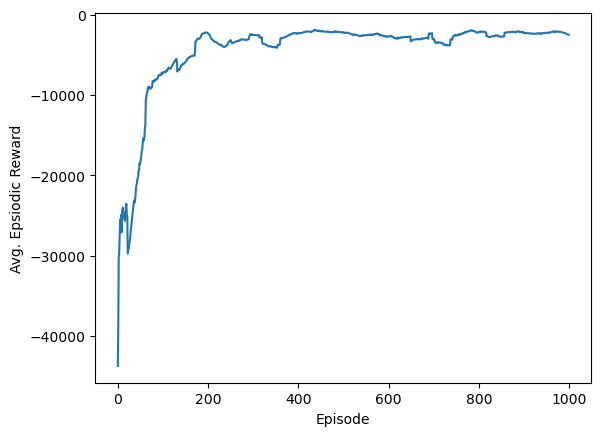

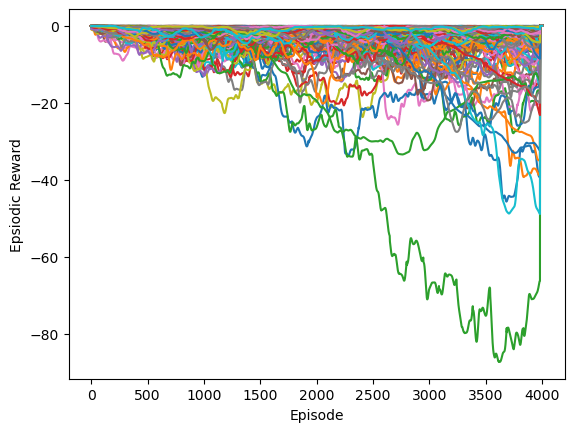

In [75]:
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Epsiodic Reward")
plt.show()    


In [88]:
np.savetxt('reward_pg.txt', ep_reward_list) 
np.savetxt('avg_reward_pg.txt', avg_reward_list) 
np.savetxt('Jval_QC_pg.txt',np.squeeze(J_values))
ep = np.arange(0, total_episodes, 1)
np.savetxt('ep.txt',ep.T)

In [100]:
ep.shape

(1000,)

In [101]:
input = np.array([ep, np.squeeze(avg_reward_list), np.squeeze(J_values)])
print(input.T.shape)
result=np.savetxt('Reward_pg.txt', input.T, delimiter=' ')
print(result)

(1000, 3)
None


In [96]:
t.shape

(4001,)

In [118]:
np.savetxt('J_values_QCmodel_pg.txt',np.squeeze(J_values)) 
np.save('K_pg.npy', K)
np.save('dj_dk_pg.npy', dj_dk)
np.save('ep_Action_list_pg.npy', ep_Action_list)
np.save('ep_State_list_pg.npy', ep_State_list)
np.save('ep_AdState_list_pg.npy', ep_AdState_list)

In [83]:
actor_model.save_weights("q_car_state_actor_G0p05T0p9_PG.h5")
critic_model.save_weights("q_car_state_critic_G0p05T0p9_PG.h5")

target_actor.save_weights("q_car_target__state_actor_G0p05T0p9_PG.h5")
target_critic.save_weights("q_car_target__state_critic_G0p05T0p9_PG.h5")

In [90]:
# plt.plot(avg_reward_list)
# plt.xlabel("Episode")
# plt.ylabel("Avg. Epsiodic Reward")
# plt.show()
# ep_reward = np.array(ep_reward_list1)
# plt.plot(ep_reward.flatten())
# plt.xlabel("Episode")
# plt.ylabel("Epsiodic Reward")
# plt.show()    
# np.savetxt('reward_pg.txt', ep_reward.flatten()) 
# np.savetxt('avg_reward_pg.txt', avg_reward_list) 

In [33]:
K=np.load('K_pg.npy')
K[:, :, total_episodes-1]

array([[-1830.63101839,  1009.98897188,   192.23259887, -1426.03584131],
       [ 1009.98601521,  -598.48216293,  -135.30857573,   826.23508123],
       [  183.50113821,  -114.92730763,   611.86644017,   -76.97655807],
       [-1423.14407836,   819.48497699,   -77.1367164 , -1137.38132831]])

In [34]:
K.shape

(4, 4, 1000)

In [35]:
del policy
del actor_model 
del critic_model

del target_actor 
del target_critic 

In [36]:
 def policy(state):
    sampled_actions = tf.squeeze(target_actor(state))
    sampled_actions = sampled_actions.numpy() 
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

In [37]:
target_actor = get_actor()

In [38]:
#actor_model.load_weights("q_car_random_actor_0p75_0p05tau_rand_pg.h5")
#critic_model.load_weights("q_car_random_critic_0p75_0p05tau_rand_pg.h5")

target_actor.load_weights("q_car_target__state_actor_G0p05T0p9_PG.h5")
#target_critic.load_weights("q_car_target__random_critic_0p75_0p05tau_rand_pg.h5")

In [50]:
T = 40
dt = 0.01
t = np.arange(0, T+dt, dt)
nt = len(t)
x_uc = np.zeros([nt, 2*n, 6])
y_uc = np.zeros([nt, n, 6])
x_c = np.zeros([nt, 2*n, 6])
y_c = np.zeros([nt, n, 6])
x_pg = np.zeros([nt, 2*n, 6])
y_pg = np.zeros([nt, n, 6])
J1_val = np.zeros([6, 1])
J2_val = np.zeros([6, 1])
Action =  np.zeros([nt, 6])
Action1 =  np.zeros([nt, 6])
U = np.zeros([nt, 6])
ep = total_episodes-1


# Input Sinusoid (Resonant Frequencies)
k = 0
for i in range(1, 3):
    for j in range(0, 3):
        omega1 = i
        omega2 = j/10
        amplitude = (np.sin(omega1*t) + np.sin(omega2*t))
        prev_state = env.reset()
        env.amplitude = amplitude
        episodic_reward = 0
        env.K = K[0:2*env.n,0:2*env.n,total_episodes-1]
        #print("omega1: ",env.omega1, "omega2: ",env.omega2/10)
        for time in range(0,len(env.t)-20):
            env.time_current = time
            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
            action = policy(tf_prev_state)
            state, reward, done, info = env.step(action)
            episodic_reward += reward
            prev_state = state
        #avg_reward = np.mean(ep_reward_list[-40:])
        #print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
        print(" J_value is ==> {}".format(env.J_val))
        
        x_pg[0:3981,:,k]=np.array([env.values[0], env.values[1], env.values[2], env.values[3]]).T
        Action[0:3981,k] = np.squeeze(env.en)
        for tkk in range(0,nt-1):
            Action1[tkk, k] = Kp1@np.array([x_pg[tkk,:,k]]).T
            y1 = (Cd @ np.array([x_pg[tkk,:,k]]).T) + (Dd*np.array([Action[tkk,k]]))
            y_pg[tkk,:,k] = y1[1:3,:].T
        # Openloop
        sys_uc = signal.StateSpace(A, E, Cd, np.array([[0, 0, 0]]).T)
        t1,y1,x1 = signal.lsim(sys_uc,amplitude,t)
        x_uc[:, :, k] = x1
        y_uc[:, :, k] = y1[:, 1:3]
        del t1, y1, x1

        sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
        t2,y2,x2 = signal.lsim(sys_c,amplitude,t)
        x_c[:, :, k] = x2
        y_c[:, :, k] = y2[:, 1:3]
        del t2, y2, x2
        k = k+1
del i, j, k
for k in range(0, 6):
    for tkk in range(0,len(t)):
        U[tkk, k] = Kp1@x_uc[tkk,:,k].T
        En1 = 0.5*((x_uc[tkk,:,k]@Qp)@x_uc[tkk,:,k].T)
        En2 = 0.5*((x_c[tkk,:,k]@Qp)@x_c[tkk,:,k].T)
        J1 = dt*En1
        J2 = dt*En2
        J1_val[k] += J1 
        J2_val[k] += J2
print(J2_val)
print(J1_val)

[[1740.41542755]] [[477.06185178]]


C:\Users\USER\anaconda3\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


 J_value is ==> [[5613.09194598]]
[[5677.31362313]] [[1074.43072589]]
 J_value is ==> [[8693.82222376]]
[[1915.56587715]] [[610.65398932]]
 J_value is ==> [[10351.17561696]]
[[9799.18375292]] [[1622.50468692]]
 J_value is ==> [[106410.17270772]]
[[5474.03557579]] [[1511.80941034]]
 J_value is ==> [[115198.13701697]]
[[7359.56866961]] [[1506.2795994]]
 J_value is ==> [[116814.025358]]
[[  5928.99190045]
 [  8733.96223775]
 [ 11061.43139842]
 [324668.77360252]
 [327550.04836975]
 [331324.32428298]]
[[   7730.66149397]
 [  10964.3944059 ]
 [  14641.84077091]
 [1421112.01140244]
 [1431401.70678702]
 [1439467.14511079]]


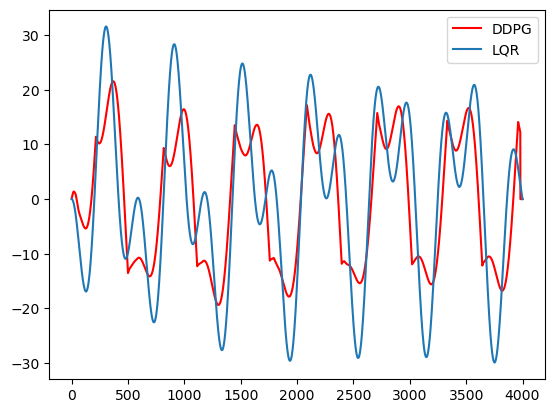

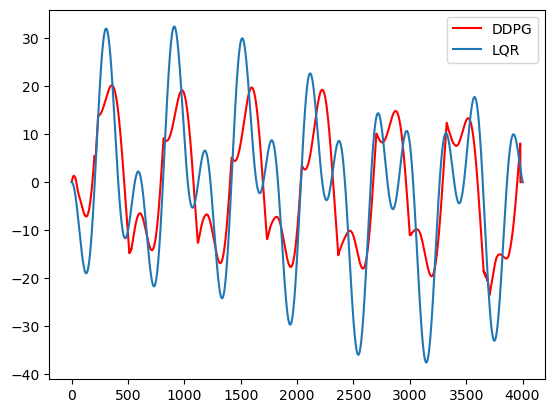

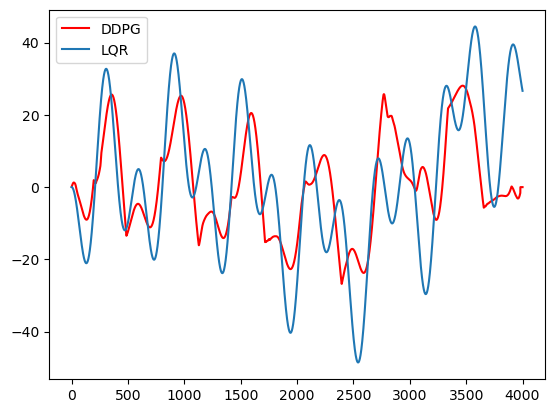

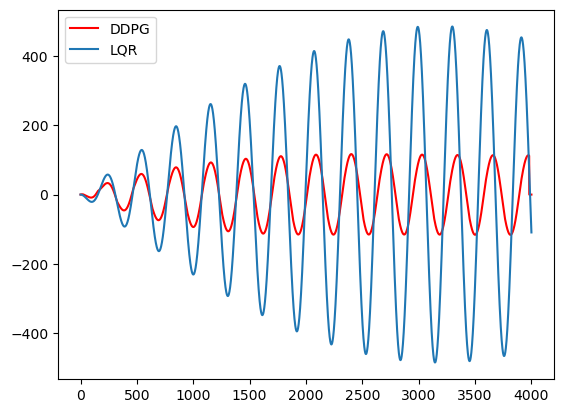

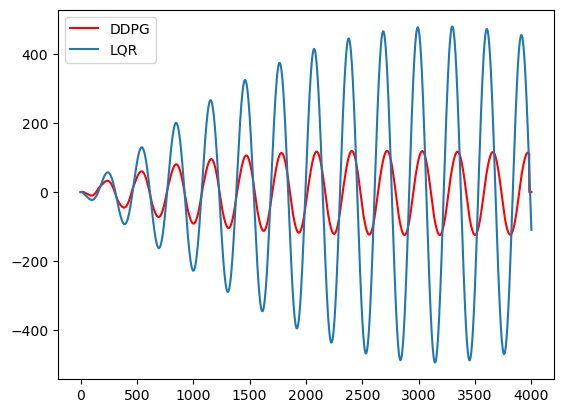

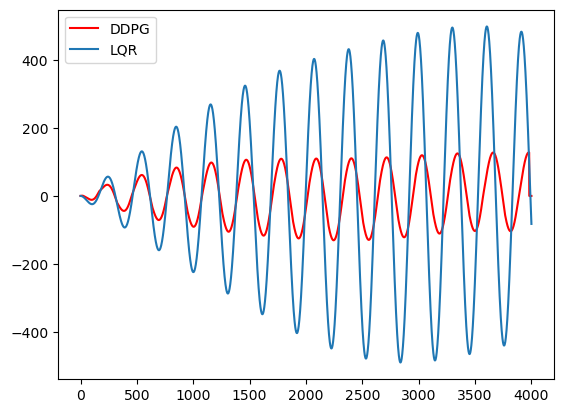

In [54]:
plt.figure()
plt.plot(Action1[:,0],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(U[:,0] ,label = "LQR")
plt.legend()

plt.figure()
plt.plot(Action1[:,1],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(U[:,1] ,label = "LQR")
plt.legend()

plt.figure()
plt.plot(Action1[:,2],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(U[:,2] ,label = "LQR")
plt.legend()

plt.figure()
plt.plot(Action1[:,3],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(U[:,3] ,label = "LQR")
plt.legend()


plt.figure()
plt.plot(Action1[:,4],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(U[:,4] ,label = "LQR")
plt.legend()

plt.figure()
plt.plot(Action1[:,5],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(U[:,5] ,label = "LQR")
plt.legend()

In [55]:
input = np.array([t, Action1[:,0], U[:,0], Action1[:,3], U[:,3]])
print(input.T.shape)
result=np.savetxt('Force_ddpg_pg.txt', input.T, delimiter=' ')
print(result)

(4001, 5)
None


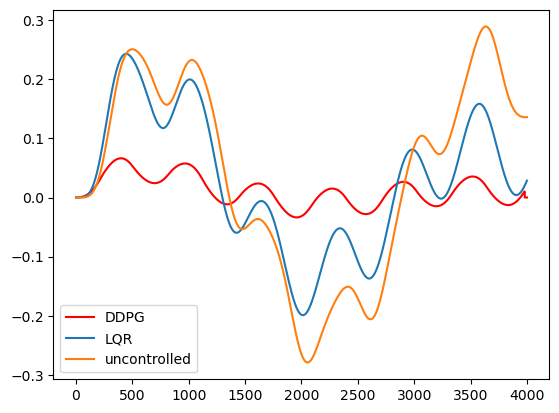

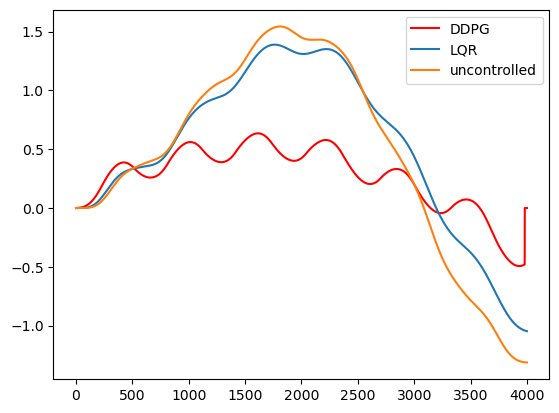

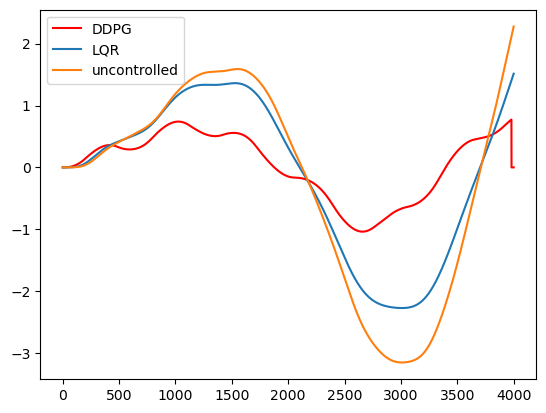

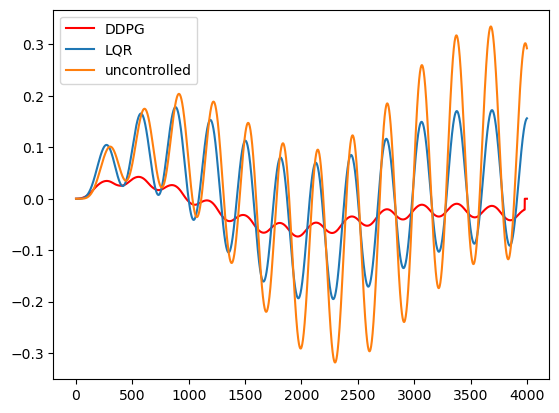

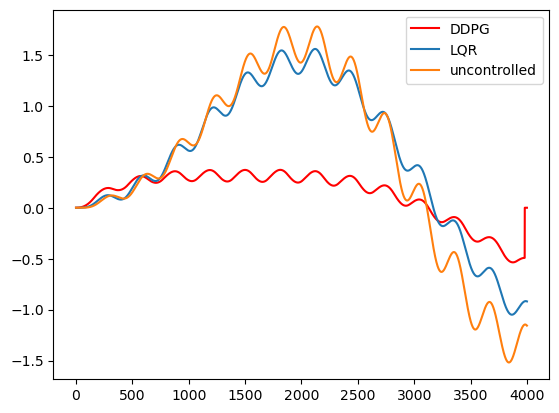

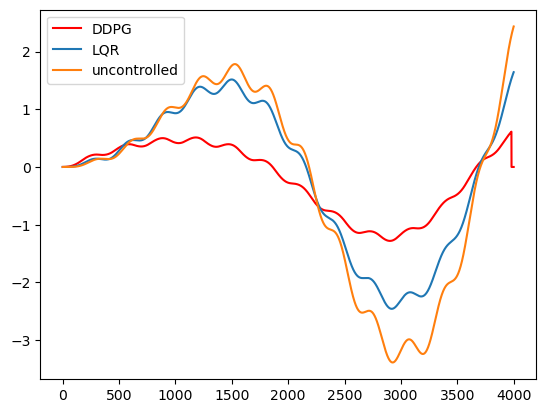

In [42]:
plt.figure()
plt.plot(0.1*x_pg[:,0,0],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(x_c[:,0,0] ,label = "LQR")
plt.plot(x_uc[:,0,0] ,label = "uncontrolled")
plt.legend()

plt.figure()
plt.plot(0.5*x_pg[:,0,1],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(x_c[:,0,1] ,label = "LQR")
plt.plot(x_uc[:,0,1] ,label = "uncontrolled")
plt.legend()

plt.figure()
plt.plot(0.5*x_pg[:,0,2],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(x_c[:,0,2] ,label = "LQR")
plt.plot(x_uc[:,0,2] ,label = "uncontrolled")
plt.legend()

plt.figure()
plt.plot(0.1*x_pg[:,0,3],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(x_c[:,0,3] ,label = "LQR")
plt.plot(x_uc[:,0,3] ,label = "uncontrolled")
plt.legend()

plt.figure()
plt.plot(0.5*x_pg[:,0,4],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(x_c[:,0,4] ,label = "LQR")
plt.plot(x_uc[:,0,4] ,label = "uncontrolled")
plt.legend()

plt.figure()
plt.plot(0.5*x_pg[:,0,5],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(x_c[:,0,5] ,label = "LQR")
plt.plot(x_uc[:,0,5] ,label = "uncontrolled")
plt.legend()



In [43]:
input = np.array([t, 0.1*x_pg[:,0,0], x_c[:,0,0], x_uc[:,0,0], 0.1*x_pg[:,0,3], x_c[:,0,3], x_uc[:,0,3]])
print(input.T.shape)
result=np.savetxt('Disp_ddpg_pg.txt', input.T, delimiter=' ')
print(result)

(4001, 7)
None


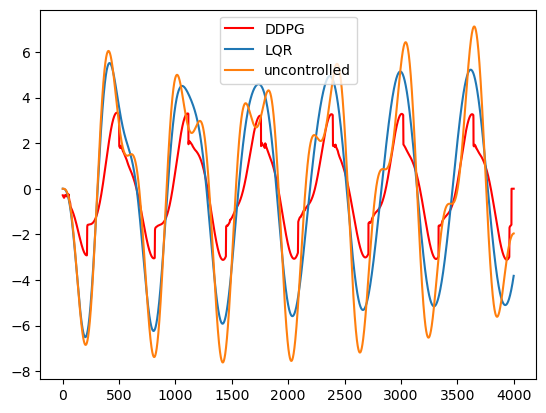

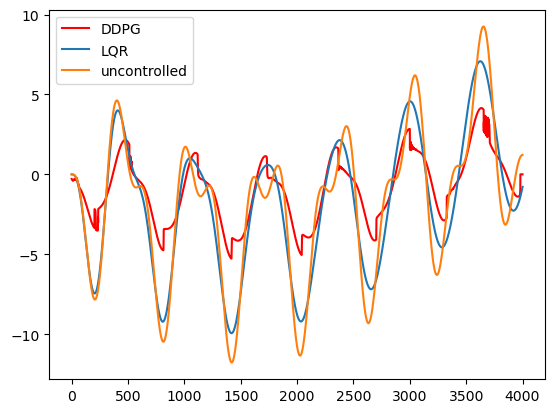

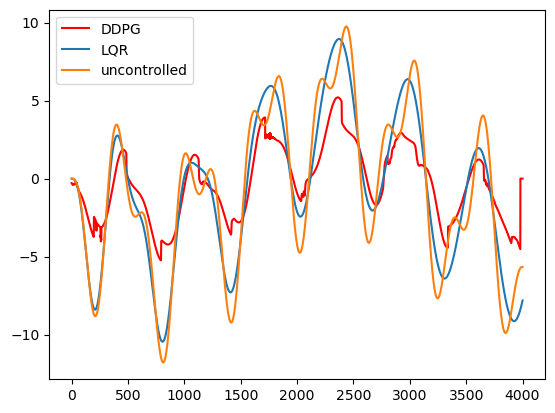

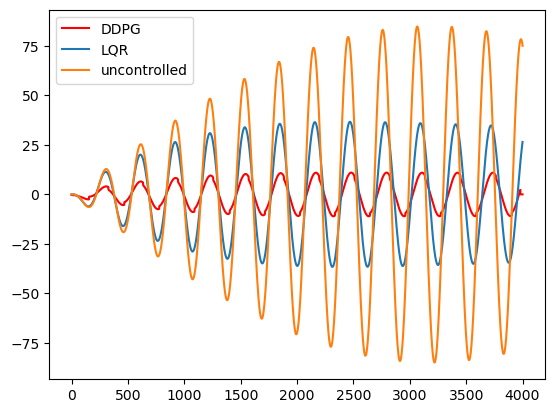

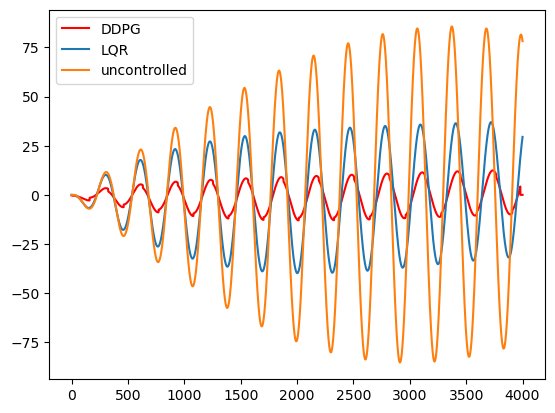

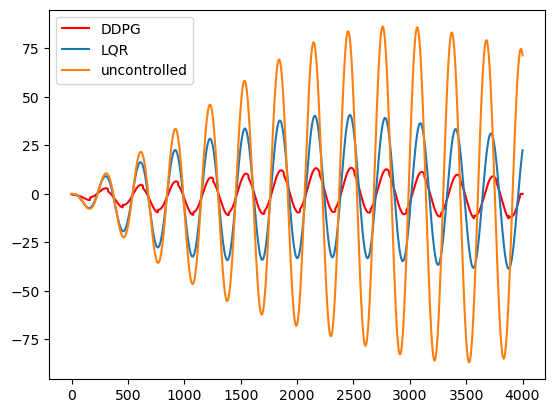

In [44]:
plt.figure()
plt.plot(0.5*y_pg[:,1,0],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(y_c[:,1,0] ,label = "LQR")
plt.plot(y_uc[:,1,0] ,label = "uncontrolled")
plt.legend()

plt.figure()
plt.plot(0.5*y_pg[:,1,1],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(y_c[:,1,1] ,label = "LQR")
plt.plot(y_uc[:,1,1] ,label = "uncontrolled")
plt.legend()

plt.figure()
plt.plot(0.5*y_pg[:,1,2],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(y_c[:,1,2] ,label = "LQR")
plt.plot(y_uc[:,1,2] ,label = "uncontrolled")
plt.legend()

plt.figure()
plt.plot(0.5*y_pg[:,1,3],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(y_c[:,1,3] ,label = "LQR")
plt.plot(y_uc[:,1,3] ,label = "uncontrolled")
plt.legend()

plt.figure()
plt.plot(0.5*y_pg[:,1,4],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(y_c[:,1,4] ,label = "LQR")
plt.plot(y_uc[:,1,4] ,label = "uncontrolled")
plt.legend()

plt.figure()
plt.plot(0.5*y_pg[:,1,5],'r',label='DDPG')
#plt.plot(env.amplitude,label="path")
plt.plot(y_c[:,1,5] ,label = "LQR")
plt.plot(y_uc[:,1,5] ,label = "uncontrolled")
plt.legend()

In [45]:
input = np.array([t, 0.5*y_pg[:,1,0], y_c[:,1,0], y_uc[:,1,0],  0.5*y_pg[:,1,3], y_c[:,1,3], y_uc[:,1,3]])
print(input.T.shape)
result=np.savetxt('Acc_ddpg_pg.txt', input.T, delimiter=' ')
print(result)

(4001, 7)
None


In [49]:
U.shape

(4001, 6)

[[13044.80180137]] [[2087.10278072]]
Episode * 0 * Reward is ==> [[-30703.13940729]]
Episode * 0 * J_value is ==> [[3487.74213712]]
[1932.66537349] [1482.24797511]


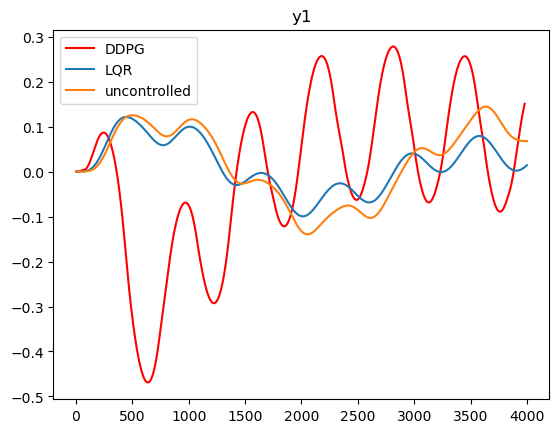

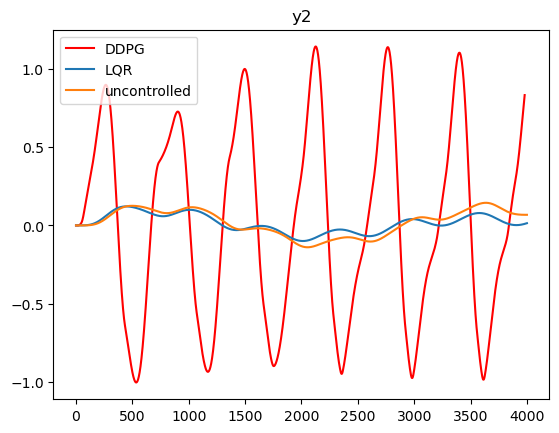

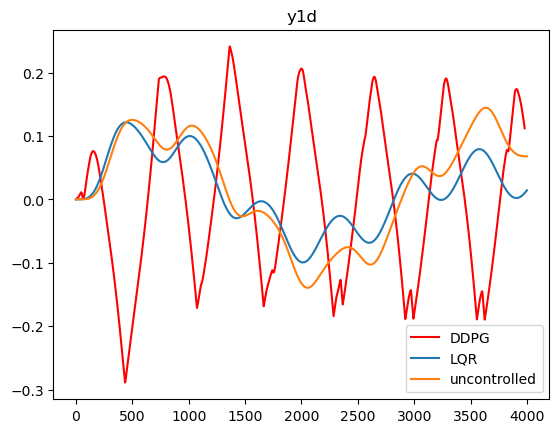

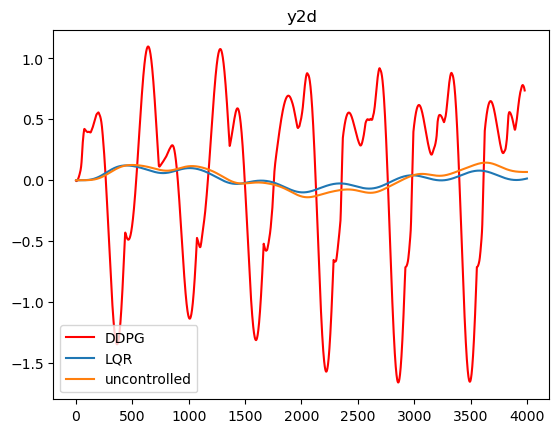

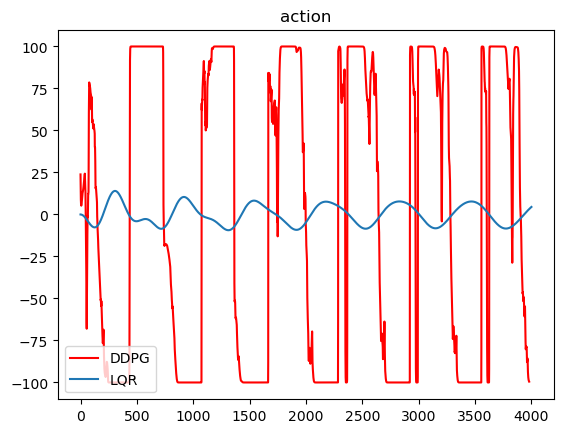

[[9361.64324242]] [[1822.39976317]]


C:\Users\USER\anaconda3\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 1 * Reward is ==> [[-30703.13940729]]
Episode * 1 * J_value is ==> [[3487.74213712]]
[1932.66537349] [1482.24797511]


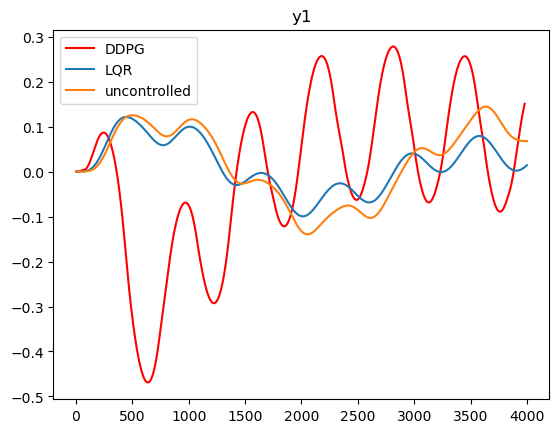

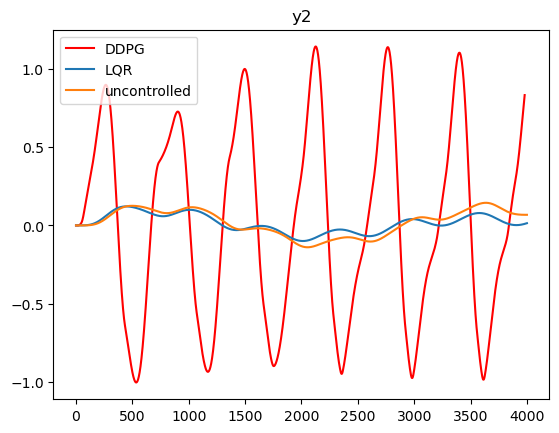

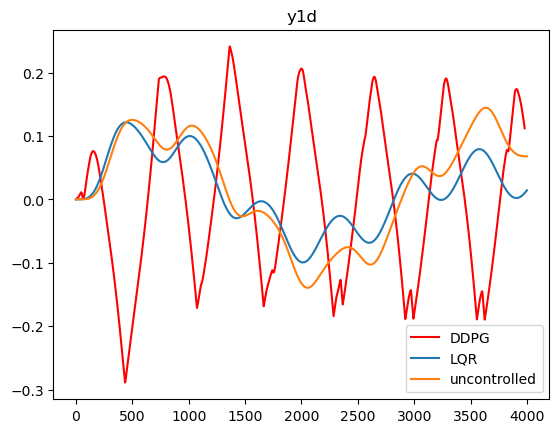

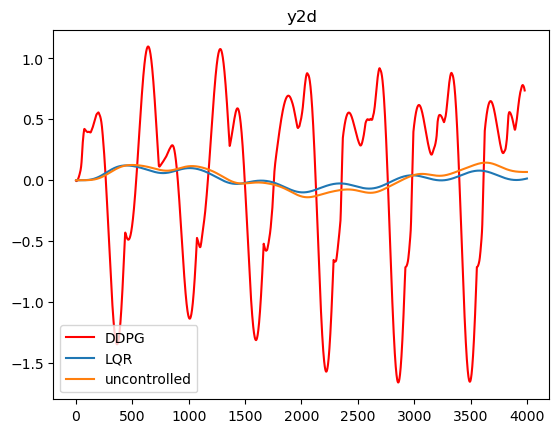

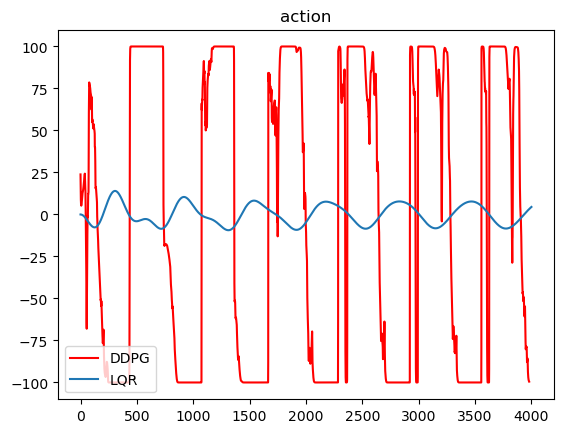

[[2521.29039506]] [[826.74457947]]


C:\Users\USER\anaconda3\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 2 * Reward is ==> [[-30703.13940729]]
Episode * 2 * J_value is ==> [[3487.74213712]]
[1932.66537349] [1482.24797511]


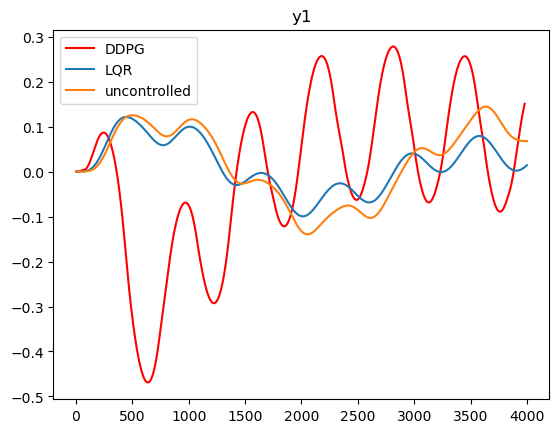

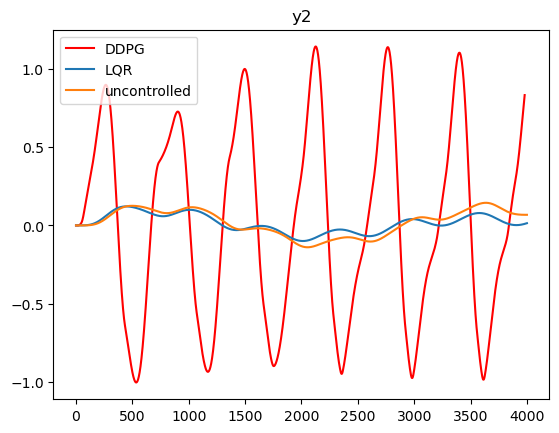

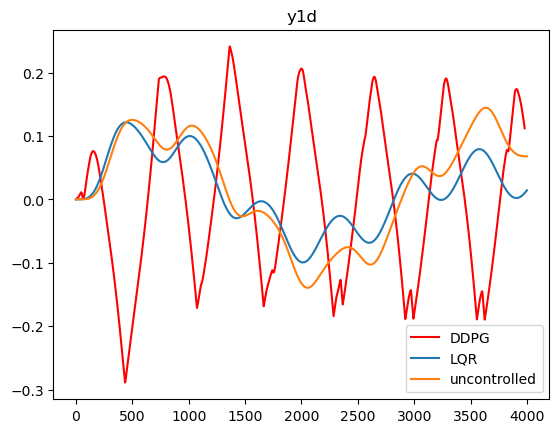

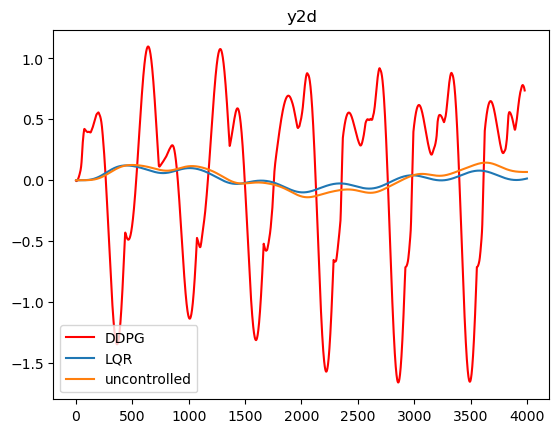

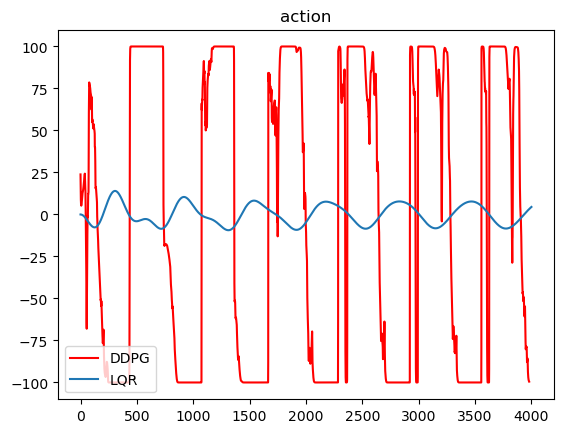

[[2529.57149787]] [[1590.25354511]]


C:\Users\USER\anaconda3\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 3 * Reward is ==> [[-30703.13940729]]
Episode * 3 * J_value is ==> [[3487.74213712]]
[1932.66537349] [1482.24797511]


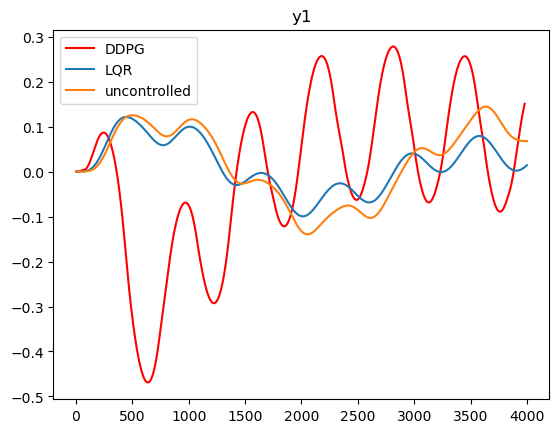

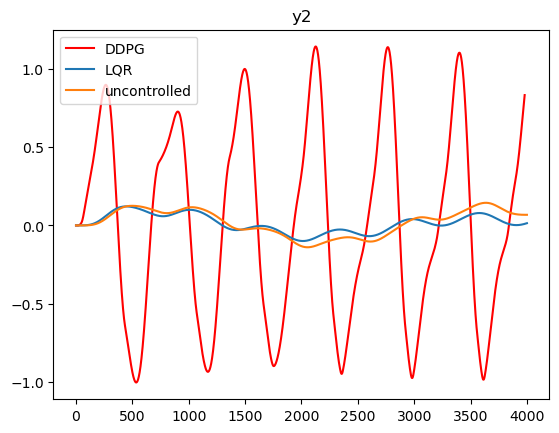

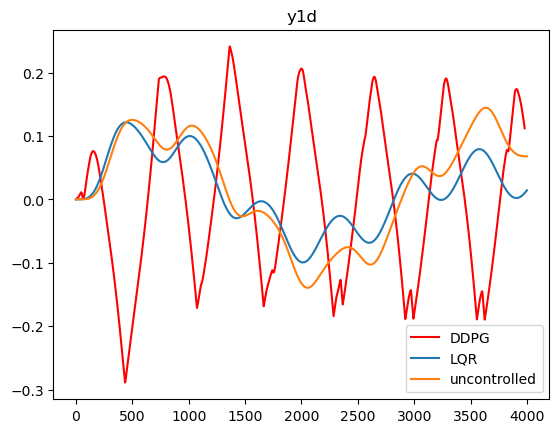

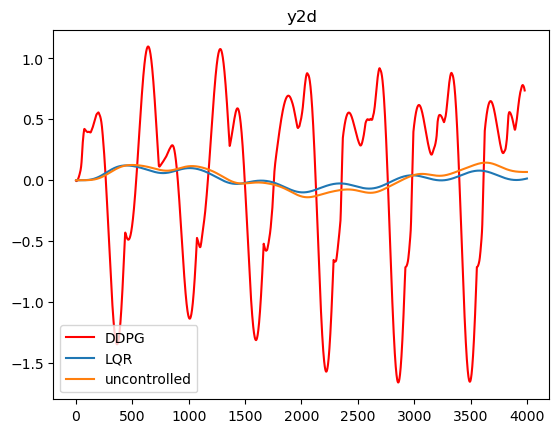

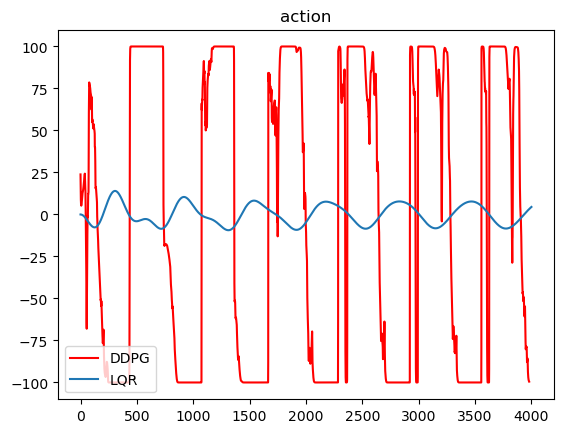

[[8738.30044141]] [[1911.10408307]]


C:\Users\USER\anaconda3\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 4 * Reward is ==> [[-30703.13940729]]
Episode * 4 * J_value is ==> [[3487.74213712]]
[1932.66537349] [1482.24797511]


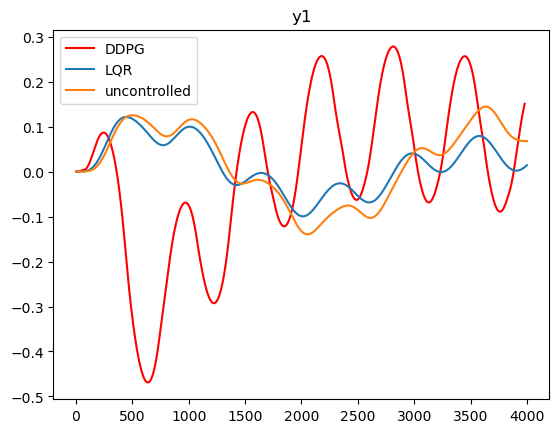

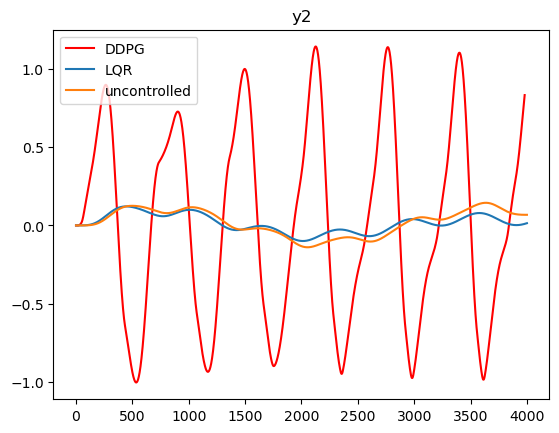

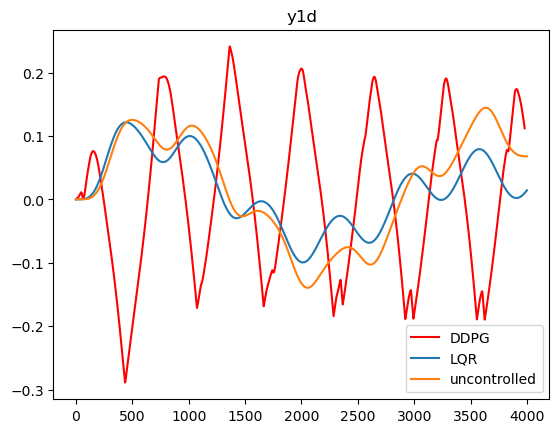

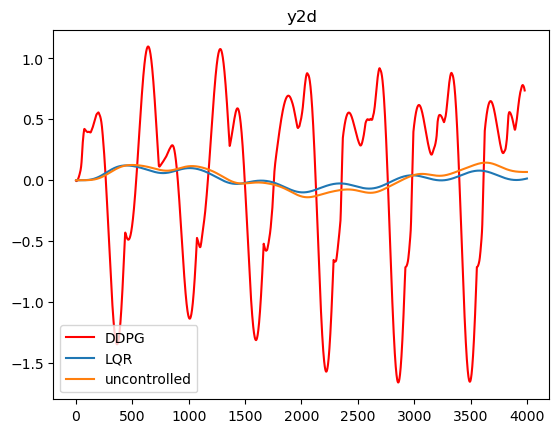

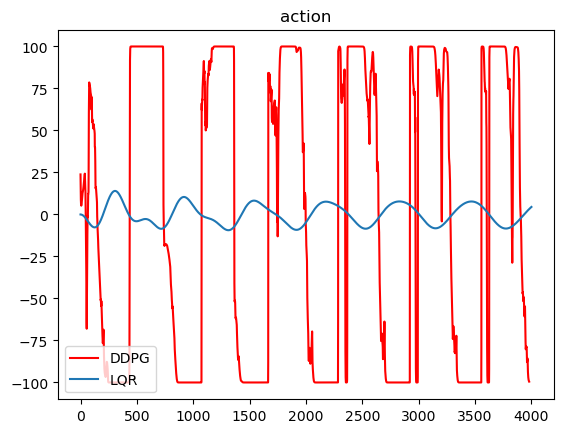

[[751.29686009]] [[457.78454625]]


C:\Users\USER\anaconda3\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 5 * Reward is ==> [[-30703.13940729]]
Episode * 5 * J_value is ==> [[3487.74213712]]
[1932.66537349] [1482.24797511]


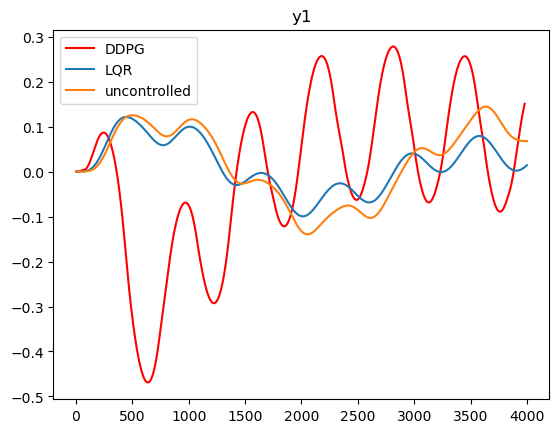

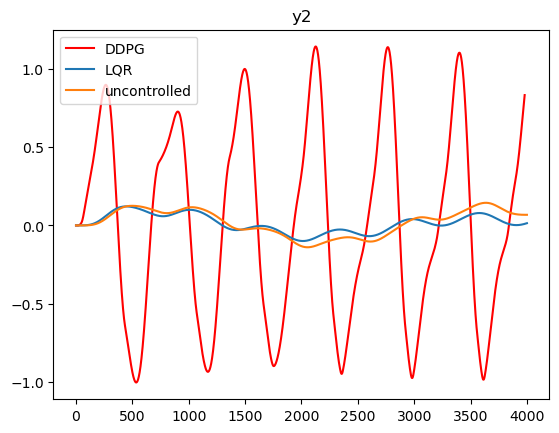

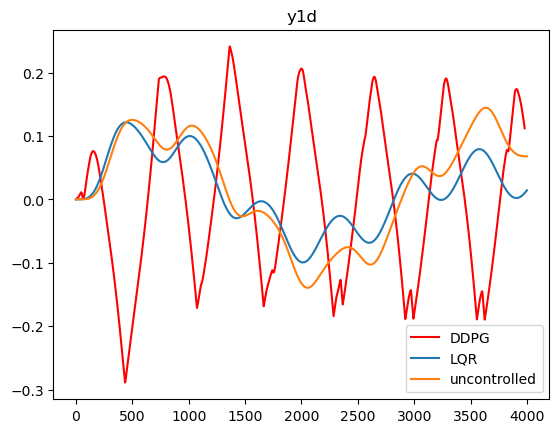

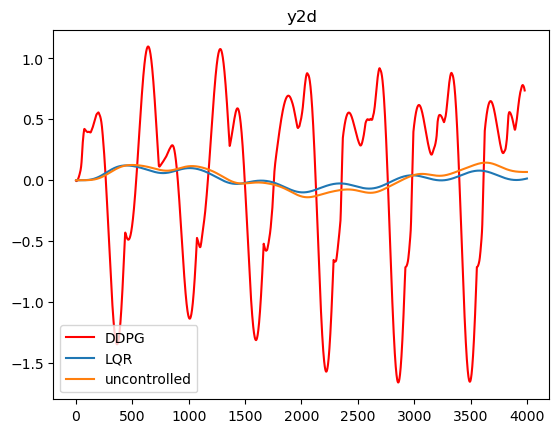

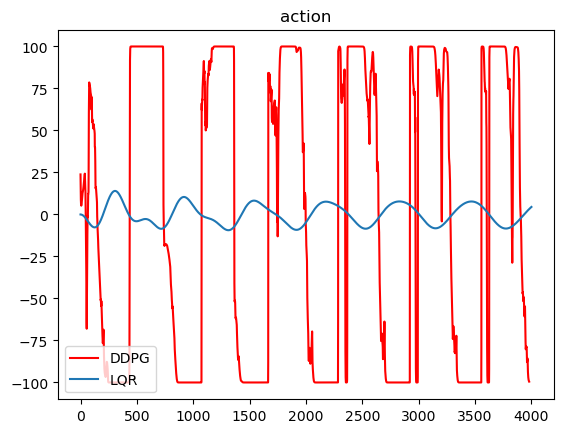

In [26]:
# ep_reward = []
# avg_reward = []
# r = 0
# rewa = []
# J_vals = []
# act = []
# j = 0
# vals = []
# k = 0
# A =np.array([[0 ,0 ,1 ,0 ],
#               [0 ,0 ,0 ,1 ],
#               [-Ks/M, Ks/M, 0, 0],
#               [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
# # Input matrix (Control force and Earthquake input)
# B  = np.array([[0,0,1/M,-1/m]]).T
# # Influence vector (Earthquake input)
# E = np.array([[0,0,0,Kt/m]]).T 
# # Output matrix (Disp + Accel)
# Cd = np.array([[1, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
# Dd = np.array([[0, 1/M, -1/m]]).T
# Ed = np.array([[0, 0, 0]]).T
# Qp = np.array([[Ks, -Ks, 0, 0],
#                [-Ks, Ks+Kt, 0, 0],
#                [0, 0, M, 0],
#                [0, 0, 0, m]])
# # print(Qp)
# (i,j)=B.shape
# Rp =  (10**(0))*np.identity(j)
# Kp1, Sp1, ep1 = ct.lqr(A, B, Qp, Rp)
# del i, j

# T = 40
# dt = 0.01

# nt = len(env.t)
# x_uc = np.zeros([nt, 2*n, 6])
# y_uc = np.zeros([nt, n, 6])
# x_c = np.zeros([nt, 2*n, 6])
# y_c = np.zeros([nt, n, 6])
# J1_val = np.zeros([6, 1])
# J2_val = np.zeros([6, 1])
# U = np.zeros([nt, 6])
# for ep in range(6):
#     prev_state = env.reset()
#     env.amplitude = 0.5*(np.sin(env.t))
#     episodic_reward = 0
#     vals.append([])
#     #print("omega1: ",env.omega1, "omega2: ",env.omega2/10)
#     for time in range(0,len(env.t)-20):
#         env.time_current = time
#         tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
#         action = policy(tf_prev_state)
#         state, reward, done, info = env.step(action)
#         episodic_reward += reward
#         prev_state = state

#     ep_reward.append(episodic_reward)
#     J_vals.append(env.J_val)
#     act.append(env.en) 
#     vals[ep].append(env.values)
#     #avg_reward = np.mean(ep_reward_list[-40:])
#     print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
#     print("Episode * {} * J_value is ==> {}".format(ep, env.J_val))
   
#     amplitude = env.amplitude
#     t = env.t
#     sys_uc = signal.StateSpace(A, E, Cd, np.array([[0, 0, 0]]).T)
#     t1,y1,x1 = signal.lsim(sys_uc,amplitude,t)
#     x_uc[:, :, k] = x1
#     y_uc[:, :, k] = y1[:, 1:3]
#     del t1, y1, x1

#     sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
#     t2,y2,x2 = signal.lsim(sys_c,amplitude,t)
#     x_c[:, :, k] = x2
#     y_c[:, :, k] = y2[:, 1:3]
#     del t2, y2, x2
#     for tkk in range(0,len(t)):
#         U[tkk, k] = Kp1@x_c[tkk,:,k].T
#         En1 = 0.5*((x_uc[tkk,:,k]@Qp)@x_uc[tkk,:,k].T)
#         En2 = 0.5*((x_c[tkk,:,k]@Qp)@x_c[tkk,:,k].T)
#         J1 = dt*En1
#         J2 = dt*En2
#         J1_val[k] += J1 
#         J2_val[k] += J2
#     print(J1_val[k],J2_val[k])
#     k = k+1
#     plt.figure()
#     plt.plot(vals[-1][0][0],'r',label='DDPG')
#     #plt.plot(env.amplitude,label="path")
#     plt.plot(x_c[:,0,k-1] ,label = "LQR")
#     plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
#     plt.legend()
#     plt.title('y1')
#     plt.show()
#     plt.figure()
#     plt.plot(vals[-1][0][1],'r',label='DDPG')
#     #plt.plot(env.amplitude,label="path")
#     plt.plot(x_c[:,0,k-1] ,label = "LQR")
#     plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
#     plt.legend()
#     plt.title('y2')
#     plt.show()
#     plt.figure()
#     plt.plot(vals[-1][0][2],'r',label='DDPG')
#     #plt.plot(env.amplitude,label="path")
#     plt.plot(x_c[:,0,k-1] ,label = "LQR")
#     plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
#     plt.legend()
#     plt.title('y1d')
#     plt.show()
#     plt.figure()
#     plt.plot(vals[-1][0][3],'r',label='DDPG')
#     #plt.plot(env.amplitude,label="path")
#     plt.plot(x_c[:,0,k-1] ,label = "LQR")
#     plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
#     plt.legend()
#     plt.title('y2d')
#     plt.show()
#     plt.figure()
#     plt.plot(act[-1],'r',label='DDPG')
#     plt.plot(U[:, k-1] ,label = "LQR")
    
#     plt.legend()
#     plt.title('action')
#     plt.show()

In [65]:
env.en

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
K[0:2*env.n,0:2*env.n,0] 

In [ ]:
K[0:2*env.n,0:2*env.n,999] 

In [ ]:
# Initial controller gain
P = np.array([[-5.60388195e+02,  1.85873971e+02, -3.35420000e+02, -5.03729674e+00],
               [ 1.85873971e+02, -2.01982759e+03,  4.26409397e+02, -3.23571106e+01],
               [-3.35420000e+02,  4.26409397e+02, -1.14986282e+04, -1.02322121e+02],
               [-5.03729674e+00, -3.23571106e+01, -1.02322121e+02, -4.55606248e+02]])
Bj  = np.array([[0,0,0,0], [0,0,0,0], [-0.49590136/env.M, 1.14546156/env.M, -35.69758159/env.M, 11.83173935/env.M], [0.49590136/env.m, -1.14546156/env.m, 35.69758159/env.m, -11.83173935/env.m]]) 
K0 = P@Bj
K = np.zeros([2*env.n, 2*env.n, total_episodes])
K[0:2*env.n,0:2*env.n,0] = K0

In [ ]:
ep_State_list = np.zeros([env.t.size, 2*env.n, total_episodes])
ep_AdState_list = np.zeros([env.t.size, 2*env.n, total_episodes])
xn = np.array([ep_State_list[0,:,0]]).T
pn = np.array([ep_AdState_list[0,:,0]]).T
d_ptau = (0.02-1)*((pn.T@Bj)@xn)*((K[0:2*env.n,0:2*env.n,0] + K[0:2*env.n,0:2*env.n,0].T)@xn)
pnb1 = pn + d_ptau  # (n*1)
ep_AdState_list[1,:,0] = pnb1.T
ep_AdState_list[1,:,0]
pnb1.T

In [ ]:
plt.plot(env.Volt)

In [ ]:
plt.plot(actions[0])

In [ ]:
plt.plot(actions[16])

In [ ]:
plt.plot(actions[99])

In [ ]:
plt.plot(actions[498])

In [ ]:
# Save the weights
actor_model.save_weights("qcar_actor.h5")
critic_model.save_weights("qcar_critic.h5")

target_actor.save_weights("qcar_target_actor.h5")
target_critic.save_weights("qcar_target_critic.h5")

In [ ]:
plt.plot(ep_reward_list)


In [ ]:

plt.plot(values[30][0][0],label='episode 100')
plt.plot(values[99][0][0],label='episode ')
 
plt.legend()
plt.show()

In [ ]:
plt.plot(env.hr)

In [ ]:
plt.plot(J_values)

In [ ]:
plt.plot(ep_reward_list)


In [ ]:
plt.plot(actions[149])

In [ ]:
plt.plot(actions[145])

In [ ]:
plt.plot(actions[141])

In [48]:
T = 40
dt = 0.01
t = np.arange(0, T+dt, dt)
nt = len(t)
x_uc = np.zeros([nt, 2*n, 6])
y_uc = np.zeros([nt, n, 6])
x_c = np.zeros([nt, 2*n, 6])
y_c = np.zeros([nt, n, 6])
J1_val = np.zeros([6, 1])
J2_val = np.zeros([6, 1])
U = np.zeros([nt, 6])


# Input Sinusoid (Resonant Frequencies)
k = 0
for i in range(1, 3):
    for j in range(0, 3):
        omega1 = i
        omega2 = j/10
        amplitude = (np.sin(omega1*t) + np.sin(omega2*t))
        prev_state = env.reset()
        env.amplitude = amplitude
        episodic_reward = 0
        #print("omega1: ",env.omega1, "omega2: ",env.omega2/10)
        for time in range(0,len(env.t)-20):
            env.time_current = time
            state, reward, done, info = env.step(0)
            episodic_reward += reward
            prev_state = state
        #avg_reward = np.mean(ep_reward_list[-40:])
        #print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
        print("Episode * {} * J_value is ==> {}".format(ep, env.J_val))
        
        
        # Openloop
        sys_uc = signal.StateSpace(A, E, Cd, np.array([[0, 0, 0]]).T)
        t1,y1,x1 = signal.lsim(sys_uc,amplitude,t)
        x_uc[:, :, k] = x1
        y_uc[:, :, k] = y1[:, 1:3]
        del t1, y1, x1

        sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
        t2,y2,x2 = signal.lsim(sys_c,amplitude,t)
        x_c[:, :, k] = x2
        y_c[:, :, k] = y2[:, 1:3]
        del t2, y2, x2
        k = k+1
del i, j, k
for k in range(0, 6):
    for tkk in range(0,len(t)):
        U[tkk, k] = Kp1@x_uc[tkk,:,k].T
        En1 = 0.5*((x_uc[tkk,:,k]@Qp)@x_uc[tkk,:,k].T)
        En2 = 0.5*((x_c[tkk,:,k]@Qp)@x_c[tkk,:,k].T)
        J1 = dt*En1
        J2 = dt*En2
        J1_val[k] += J1 
        J2_val[k] += J2
print(J1_val,J2_val)

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 999 * J_value is ==> [[7869.23309936]]
Episode * 999 * J_value is ==> [[11130.49059691]]
Episode * 999 * J_value is ==> [[14766.61051443]]
Episode * 999 * J_value is ==> [[1476452.22526469]]
Episode * 999 * J_value is ==> [[1486409.6745727]]
Episode * 999 * J_value is ==> [[1496537.132115]]
[[   7730.66149397]
 [  10964.3944059 ]
 [  14641.84077091]
 [1421112.01140244]
 [1431401.70678702]
 [1439467.14511079]] [[  5928.99190045]
 [  8733.96223775]
 [ 11061.43139842]
 [324668.77360256]
 [327550.0483698 ]
 [331324.32428302]]
